In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import datetime
import rasterio
import zipfile
import os
import csv
import snapista
import sys
sys.path.append('/home/ebuccoliero/miniforge3/envs/snappp/snap/.snap/snap-python/snappy')
import snappy
import pyroSAR
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import h5py

from pyproj import CRS
from cartopy.io.img_tiles import OSM
from matplotlib.patches import Rectangle
from snappy import ProductIO, GPF, HashMap
from shapely.geometry import Point
from pathlib import Path
from pprint import pprint
from ost import Sentinel1Scene
from pyroSAR import identify
from pyroSAR.snap import geocode
from snapista import Graph

INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Incompatible GDAL 3.7.0 found on system. Internal GDAL 3.0.0 from distribution will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
Currently installed 8.0, available is 11.0.0.
Please visit http://step.esa.int



In [2]:
# Load your dataset
data = pd.read_csv('final_dataset.csv')
# Create a basic plot without Cartopy
print(data.head())


   index                                        description  \
0      1  {'text': 'Iran-Iraq border region', 'type': 'F...   
1      2  {'text': 'Iran-Iraq border region', 'type': 'F...   
2      3  {'text': 'Myanmar', 'type': 'Flinn-Engdahl reg...   
3      4  {'text': 'Gulf of California', 'type': 'Flinn-...   
4      5  {'text': 'Fiji Islands region', 'type': 'Flinn...   

                      time  latitude  longitude     depth  magnitude  \
0  2018-01-11 06:59:31.600   33.7388    45.7501   19388.0       5.58   
1  2018-01-11 08:00:40.440   33.7047    45.7355   19493.5       5.37   
2  2018-01-11 18:26:24.180   18.3513    95.9959   11230.7       5.97   
3  2018-01-19 16:17:44.780   26.6196  -110.9457   10000.0       5.65   
4  2018-01-25 10:41:13.430  -17.8051  -179.5737  627266.3       4.82   

  magnitude_type                                   image_ids_before  \
0             mb  S1A_IW_SLC__1SDV_20180106T025411_20180106T0254...   
1             mb  S1A_IW_SLC__1SDV_20180110T14

In [7]:
# Load your dataset
data = pd.read_csv('final_dataset.csv')

# Check for non-numeric values and NaNs
print(data[['latitude', 'longitude']].info())
print(data[['latitude', 'longitude']].describe())
print(data[['latitude', 'longitude']].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477 entries, 0 to 476
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   477 non-null    float64
 1   longitude  477 non-null    float64
dtypes: float64(2)
memory usage: 7.6 KB
None
         latitude   longitude
count  477.000000  477.000000
mean    21.783176   29.916549
std     21.870688  108.641122
min    -40.732100 -179.852100
25%      6.858700  -74.099000
50%     22.683000   53.426100
75%     38.114200  125.264400
max     71.525000  178.097800
   latitude  longitude
0   33.7388    45.7501
1   33.7047    45.7355
2   18.3513    95.9959
3   26.6196  -110.9457
4  -17.8051  -179.5737


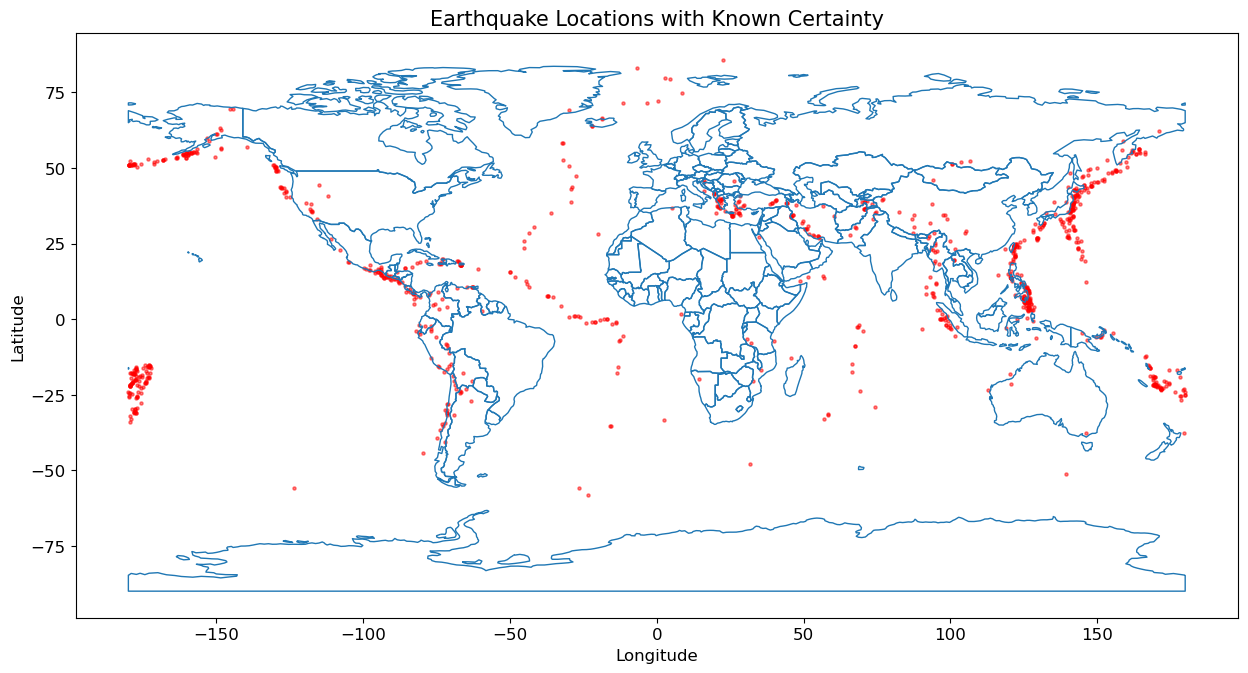

In [4]:
dfp = pd.read_csv('df_all_earthquake.csv')
dfp1 = dfp[['latitude', 'longitude']].copy()
# Crea una colonna 'geometry' con punti geografici
# Crea una colonna 'geometry' con punti geografici
geometry = [Point(x,y) for x,y in zip(dfp1['longitude'], dfp1['latitude'])]

#gdf=gpd.GeoSeries(geometry, crs=crs)
gdf = gpd.GeoDataFrame(dfp1, geometry=geometry, crs='epsg:4326')



# Specifica il sistema di coordinate (ad esempio WGS84)
#gdf.set_crs(epsg=3857, inplace=True)

# Carica il dataset dei confini dei paesi
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# Crea una figura e un asse
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Traccia i confini dei paesi
world.boundary.plot(ax=ax, linewidth=1)
#gdf.explore()
# Traccia i punti dei terremoti
gdf.plot(ax=ax, color='red', markersize=5, alpha=0.5)

# Aggiungi il titolo e le etichette
ax.set_title('Earthquake Locations with Known Certainty', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Mostra la mappa
plt.show()

In [11]:
dfp = pd.read_csv('df_all_earthquake.csv')
dfp1 = dfp[['latitude', 'longitude']].copy()
# Crea una colonna 'geometry' con punti geografici
# Crea una colonna 'geometry' con punti geografici
geometry = [Point(x,y) for x,y in zip(dfp1['longitude'], dfp1['latitude'])]

#gdf=gpd.GeoSeries(geometry, crs=crs)
gdf = gpd.GeoDataFrame(dfp1, geometry=geometry, crs='epsg:4326')

# Carica il dataset dei confini dei paesi
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

gdf.explore()


In [3]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)
df_earthquake.head(40)

index                                        description  \
0       1  {'text': 'Iran-Iraq border region', 'type': 'F...   
1       2  {'text': 'Iran-Iraq border region', 'type': 'F...   
2       3  {'text': 'Myanmar', 'type': 'Flinn-Engdahl reg...   
3       4  {'text': 'Gulf of California', 'type': 'Flinn-...   
4       5  {'text': 'Fiji Islands region', 'type': 'Flinn...   
5       6  {'text': 'Hindu Kush region', 'type': 'Flinn-E...   
6       7  {'text': 'Taiwan', 'type': 'Flinn-Engdahl regi...   
7       8  {'text': 'Taiwan', 'type': 'Flinn-Engdahl regi...   
8       9  {'text': 'Taiwan', 'type': 'Flinn-Engdahl regi...   
9      10  {'text': 'Taiwan', 'type': 'Flinn-Engdahl regi...   
10     11  {'text': 'Vanuatu Islands', 'type': 'Flinn-Eng...   
11     12  {'text': 'Taiwan', 'type': 'Flinn-Engdahl regi...   
12     13  {'text': 'Near coast of Jalisco', 'type': 'Fli...   
13     14  {'text': 'Oaxaca', 'type': 'Flinn-Engdahl regi...   
14     15  {'text': 'Oaxaca', 'type': 'Flinn-Engdahl regi...   
15     16  {'text': 'Kuril Islands', 'type': 'Flinn-Engda...   
16     17  {'text': 'Kuril Islands', 'type': 'Flinn-Engda...   
17     18  {'text': 'Tajikistan', 'type': 'Flinn-Engdahl ...   
18     19  {'text': 'Mindanao', 'type': 'Flinn-Engdahl re...   
19     20  {'text': 'Near coast of Guatemala', 'type': 'F...   
20     21  {'text': 'Western Honshu', 'type': 'Flinn-Engd...   
21     22  {'text': 'Near coast of Oaxaca', 'type': 'Flin...   
22     23  {'text': 'Southern Iran', 'type': 'Flinn-Engda...   
23     24  {'text': 'Tonga Islands', 'type': 'Flinn-Engda...   
24     25  {'text': 'Colombia', 'type': 'Flinn-Engdahl re...   
25     26  {'text': 'Hokkaido region', 'type': 'Flinn-Eng...   
26     27  {'text': 'Luzon', 'type': 'Flinn-Engdahl region'}   
27     28  {'text': 'El Salvador', 'type': 'Flinn-Engdahl...   
28     29  {'text': 'Afghanistan-Tajikistan border region...   
29     30  {'text': 'Leyte', 'type': 'Flinn-Engdahl region'}   
30     31  {'text': 'Hokkaido region', 'type': 'Flinn-Eng...   
31     32  {'text': 'Near east coast of Kamchatka Peninsu...   
32     33  {'text': 'Tonga Islands', 'type': 'Flinn-Engda...   
33     34  {'text': 'Panama', 'type': 'Flinn-Engdahl regi...   
34     35  {'text': 'Luzon', 'type': 'Flinn-Engdahl region'}   
35     36  {'text': 'Near south coast of western Honshu',...   
36     37  {'text': 'Guatemala', 'type': 'Flinn-Engdahl r...   
37     38  {'text': 'Near coast of Venezuela', 'type': 'F...   
38     39  {'text': 'Southern Greece', 'type': 'Flinn-Eng...   
39     40  {'text': 'Near coast of Oaxaca', 'type': 'Flin...   

                       time  latitude  longitude     depth  magnitude  \
0   2018-01-11 06:59:31.600   33.7388    45.7501   19388.0       5.58   
1   2018-01-11 08:00:40.440   33.7047    45.7355   19493.5       5.37   
2   2018-01-11 18:26:24.180   18.3513    95.9959   11230.7       5.97   
3   2018-01-19 16:17:44.780   26.6196  -110.9457   10000.0       5.65   
4   2018-01-25 10:41:13.430  -17.8051  -179.5737  627266.3       4.82   
5   2018-01-31 07:07:00.470   36.4864    70.8639  201345.0       5.85   
6   2018-02-04 13:56:42.950   24.1591   121.7175   14872.1       5.63   
7   2018-02-04 14:13:13.090   24.1494   121.7589   15793.0       5.39   
8   2018-02-06 15:50:43.040   24.1140   121.7269   12856.6       5.98   
9   2018-02-06 19:15:29.330  -19.0147   169.4736    9820.0       5.35   
10  2018-02-06 18:37:58.480   23.9771   121.7667  245793.1       5.24   
11  2018-02-07 15:21:31.530   24.0687   121.8158   14752.8       5.60   
12  2018-02-09 14:05:46.860   18.9200  -104.7343   12759.4       5.56   
13  2018-02-16 23:39:38.270   16.3470   -97.9265   16122.2       6.56   
14  2018-02-19 06:56:57.510   16.3337   -97.7198   23082.5       5.74   
15  2018-03-04 19:52:52.300   45.0205   147.8710  110347.7       5.61   
16  2018-03-18 18:00:12.600   45.4040   150.0383   95645.3       5.49   
17  2018-03-29 22:54:13.490   38.6836    69.9152   14103.9       

In [11]:
# Set display option to show the full content of each column
pd.set_option('display.max_colwidth', None)

df_earthquake_first_four = df_earthquake.iloc[:, :8]
df_earthquake_first_four.head(20)

index  \
0       1   
1       2   
2       3   
3       4   
4       5   
5       6   
6       7   
7       8   
8       9   
9      10   
10     11   
11     12   
12     13   
13     14   
14     15   
15     16   
16     17   
17     18   
18     19   
19     20   

                                                            description  \
0   {'text': 'Iran-Iraq border region', 'type': 'Flinn-Engdahl region'}   
1   {'text': 'Iran-Iraq border region', 'type': 'Flinn-Engdahl region'}   
2                   {'text': 'Myanmar', 'type': 'Flinn-Engdahl region'}   
3        {'text': 'Gulf of California', 'type': 'Flinn-Engdahl region'}   
4       {'text': 'Fiji Islands region', 'type': 'Flinn-Engdahl region'}   
5         {'text': 'Hindu Kush region', 'type': 'Flinn-Engdahl region'}   
6                    {'text': 'Taiwan', 'type': 'Flinn-Engdahl region'}   
7                    {'text': 'Taiwan', 'type': 'Flinn-Engdahl region'}   
8                    {'text': 'Taiwan', 'type': 'Flinn-Engdahl region'}   
9                    {'text': 'Taiwan', 'type': 'Flinn-Engdahl region'}   
10          {'text': 'Vanuatu Islands', 'type': 'Flinn-Engdahl region'}   
11                   {'text': 'Taiwan', 'type': 'Flinn-Engdahl region'}   
12    {'text': 'Near coast of Jalisco', 'type': 'Flinn-Engdahl region'}   
13                   {'text': 'Oaxaca', 'type': 'Flinn-Engdahl region'}   
14                   {'text': 'Oaxaca', 'type': 'Flinn-Engdahl region'}   
15            {'text': 'Kuril Islands', 'type': 'Flinn-Engdahl region'}   
16            {'text': 'Kuril Islands', 'type': 'Flinn-Engdahl region'}   
17               {'text': 'Tajikistan', 'type': 'Flinn-Engdahl region'}   
18                 {'text': 'Mindanao', 'type': 'Flinn-Engdahl region'}   
19  {'text': 'Near coast of Guatemala', 'type': 'Flinn-Engdahl region'}   

                       time  latitude  longitude     depth  magnitude  \
0   2018-01-11 06:59:31.600   33.7388    45.7501   19388.0       5.58   
1   2018-01-11 08:00:40.440   33.7047    45.7355   19493.5       5.37   
2   2018-01-11 18:26:24.180   18.3513    95.9959   11230.7       5.97   
3   2018-01-19 16:17:44.780   26.6196  -110.9457   10000.0       5.65   
4   2018-01-25 10:41:13.430  -17.8051  -179.5737  627266.3       4.82   
5   2018-01-31 07:07:00.470   36.4864    70.8639  201345.0       5.85   
6   2018-02-04 13:56:42.950   24.1591   121.7175   14872.1       5.63   
7   2018-02-04 14:13:13.090   24.1494   121.7589   15793.0       5.39   
8   2018-02-06 15:50:43.040   24.1140   121.7269   12856.6       5.98   
9   2018-02-06 19:15:29.330  -19.0147   169.4736    9820.0       5.35   
10  2018-02-06 18:37:58.480   23.9771   121.7667  245793.1       5.24   
11  2018-02-07 15:21:31.530   24.0687   121.8158   14752.8       5.60   
12  2018-02-09 14:05:46.860   18.9200  -104.7343   12759.4       5.56   
13  2018-02-16 23:39:38.270   16.3470   -97.9265   16122.2       6.56   
14  2018-02-19 06:56:57.510   16.3337   -97.7198   23082.5       5.74   
15  2018-03-04 19:52:52.300   45.0205   147.8710  110347.7       5.61   
16  2018-03-18 18:00:12.600   45.4040   150.0383   95645.3       5.49   
17  2018-03-29 22:54:13.490   38.6836    69.9152   14103.9       5.62   
18  2018-04-05 03:53:39.830    6.8091   126.7515   59250.7       5.84   
19  2018-04-08 05:08:23.220   13.8437   -91.5879   52061.4       5.31   

   magnitude_type  
0              mb  
1              mb  
2              mb  
3              mb  
4              mb  
5              mb  
6              mb  
7              mb  
8              mb  
9              mb  
10             mb  
11             mb  
12             mb  
13             mb  
14             mb  
15             mb  
16             mb  
17             mb  
18             mb  
19             mb

In [12]:
# Set display option to show the full content of each column
pd.set_option('display.max_colwidth', None)

# Display the first 20 rows with full content
df_earthquake[['image_ids_before', 'image_ids_after']].head(20)

image_ids_before  \
0   S1A_IW_SLC__1SDV_20180106T025411_20180106T025439_020028_0221F4_0110   
1   S1A_IW_SLC__1SDV_20180110T145938_20180110T150005_020094_022416_45C5   
2   S1A_IW_SLC__1SDV_20180103T114629_20180103T114656_019990_0220CB_F384   
3   S1A_IW_SLC__1SDV_20180114T132118_20180114T132145_020151_0225F3_53F5   
4   S1A_IW_SLC__1SDV_20180115T173156_20180115T173226_020168_022672_7B3F   
5   S1A_IW_SLC__1SDV_20180129T131330_20180129T131357_020370_022CCB_4394   
6   S1A_IW_SLC__1SDV_20180112T215202_20180112T215232_020127_022520_AC94   
7   S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8   
8   S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8   
9   S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8   
10  S1A_IW_SLC__1SDV_20180204T071249_20180204T071317_020453_022F8B_3BAF   
11  S1A_IW_SLC__1SDV_20180205T215202_20180205T215231_020477_023046_97B4   
12  S1A_IW_SLC__1SDV_20180130T125030_20180130T125058_020384_022D45_3DBE   
13  S1A_IW_SLC__1SDV_20180127T122625_20180127T122652_020340_022BE7_3F5E   
14  S1A_IW_SLC__1SDV_20180127T122625_20180127T122652_020340_022BE7_3F5E   
15  S1A_IW_SLC__1SDV_20180222T201550_20180222T201620_020724_02381F_1F50   
16  S1A_IW_SLC__1SDV_20180313T200718_20180313T200748_021001_0240E9_6693   
17  S1A_IW_SLC__1SDV_20180323T132236_20180323T132303_021143_024571_0007   
18  S1A_IW_SLC__1SDV_20180329T212406_20180329T212433_021235_024853_E02F   
19  S1A_IW_SLC__1SDV_20180328T001347_20180328T001414_021208_024782_60F9   

                                                        image_ids_after  
0   S1A_IW_SLC__1SDV_20180118T025410_20180118T025438_020203_022783_6334  
1   S1A_IW_SLC__1SDV_20180122T145937_20180122T150004_020269_0229A4_A4C8  
2   S1A_IW_SLC__1SDV_20180115T114629_20180115T114656_020165_022657_6FED  
3   S1A_IW_SLC__1SDV_20180126T132118_20180126T132145_020326_022B7D_D29E  
4   S1A_IW_SLC__1SDV_20180127T173156_20180127T173226_020343_022BFD_0DD1  
5   S1A_IW_SLC__1SDV_20180210T131330_20180210T131357_020545_023268_A7EE  
6   S1A_IW_SLC__1SDV_20180205T215202_20180205T215231_020477_023046_97B4  
7   S1A_IW_SLC__1SDV_20180215T100056_20180215T100124_020616_0234B9_22BC  
8   S1A_IW_SLC__1SDV_20180215T100056_20180215T100124_020616_0234B9_22BC  
9   S1A_IW_SLC__1SDV_20180215T100056_20180215T100124_020616_0234B9_22BC  
10  S1A_IW_SLC__1SDV_20180216T071249_20180216T071317_020628_023520_2CC4  
11  S1A_IW_SLC__1SDV_20180217T215201_20180217T215231_020652_0235DE_6658  
12  S1A_IW_SLC__1SDV_20180211T125030_20180211T125058_020559_0232DC_6EEF  
13  S1A_IW_SLC__1SDV_20180220T122625_20180220T122651_020690_023710_6CEF  
14  S1A_IW_SLC__1SDV_20180220T122625_20180220T122651_020690_023710_6CEF  
15  S1A_IW_SLC__1SDV_20180306T201550_20180306T201620_020899_023DA8_FC88  
16  S1A_IW_SLC__1SDV_20180325T200718_20180325T200748_021176_024678_FF04  
17  S1A_IW_SLC__1SDV_20180404T132236_20180404T132303_021318_024AF6_FFBB  
18  S1A_IW_SLC__1SDV_20180410T212406_20180410T212433_021410_024DC9_D497  
19  S1A_IW_SLC__1SDV_20180409T001347_20180409T001414_021383_024CFC_907A

# Earthquake 1

In [13]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[0])
print(df_earthquake['image_ids_after'].iloc[0])

S1A_IW_SLC__1SDV_20180106T025411_20180106T025439_020028_0221F4_0110
S1A_IW_SLC__1SDV_20180118T025410_20180118T025438_020203_022783_6334


In [14]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180106T025411_20180106T025439_020028_0221F4_0110')

# create an S1Scene instance
s2 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180118T025410_20180118T025438_020203_022783_6334')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image1')

#s1.download(new_path)
#s2.download(new_path)

 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180106T025411_20180106T025439_020028_0221F4_0110
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180106
 Start Time:              025411
 Stop Time:               025439
 Absolute Orbit:          020028
 Relative Orbit:          6
 -------------------------------------------------
 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180118T025410_20180118T025438_020203_022783_6334
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180118
 Start Time:              025410
 Stop Time:               025438
 Absolute Orbi

In [20]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image1/SAR/SLC/2018/01/06/S1A_IW_SLC__1SDV_20180106T025411_20180106T025439_020028_0221F4_0110.zip'
name2 = 'Images/Image1/SAR/SLC/2018/01/18/S1A_IW_SLC__1SDV_20180118T025410_20180118T025438_020203_022783_6334.zip'
scene1_1 = identify(name1)
scene1_2 = identify(name2)
print("SCENE 1_1:\n",scene1_1)
print("\n")
print("SCENE 1_2:\n",scene1_2)

SCENE 1_1:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
cycleNumber: 129
frameNumber: 139764
lines: 42222
orbit: D
orbitNumber_abs: 20028
orbitNumber_rel: 6
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 70852
sensor: S1A
spacing: (2.329562, 13.94597)
start: 20180106T025411
stop: 20180106T025439


SCENE 1_2:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
cycleNumber: 130
frameNumber: 141187
lines: 42222
orbit: D
orbitNumber_abs: 20203
orbitNumber_rel: 6
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 70849
sensor: S1A
spacing: (2.329562, 13.94596)
start: 20180118T025410
stop: 20180118T025438


In [21]:
# Access and print corner coordinates
print("Corner Coordinates for SCENE 1:")
for coord in scene1_1.coordinates:
    print(coord)

print("\nCorner Coordinates for SCENE 2:")
for coord in scene1_2.coordinates:
    print(coord)

Corner Coordinates for SCENE 1:


AttributeError: object has no attribute 'coordinates'

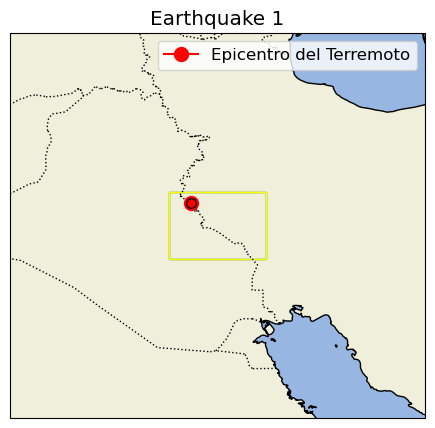

In [5]:
#EARTHQUAKE 1
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = [(47.716835, 31.984529), (45.073318, 32.38702), (45.406967, 34.067097), (48.103607, 33.666805)]
bbox_coords2 =[(47.715778, 31.983189), (45.07235, 32.385632), (45.40601, 34.065964), (48.102566, 33.665718)]
# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])


xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])


# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[0]
epicenter_lon = df_earthquake['longitude'].iloc[0]
#print(epicenter_lat, epicenter_lon)

# Creare una figura e una proiezione cartografica
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Aggiungere caratteristiche della terra
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Aggiungere il rettangolo del bbox
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1,
                 linewidth=1, edgecolor='green', facecolor='none')

# Aggiungere il rettangolo del bbox
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2,
                 linewidth=1, edgecolor='yellow', facecolor='none')


ax.add_patch(rect1)
ax.add_patch(rect2)


# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=50, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 1')

# Visualizzare la mappa
plt.show()

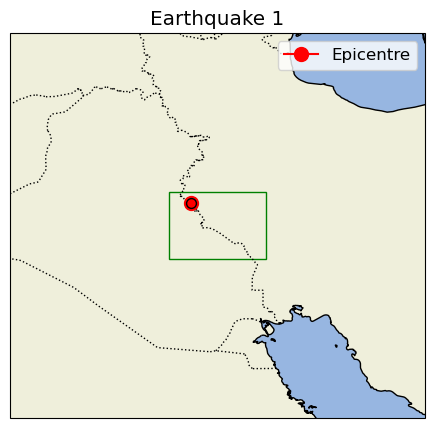

In [9]:
#EARTHQUAKE 1
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = [(47.716835, 31.984529), (45.073318, 32.38702), (45.406967, 34.067097), (48.103607, 33.666805)]
 #bbox_coords2 =[(47.715778, 31.983189), (45.07235, 32.385632), (45.40601, 34.065964), (48.102566, 33.665718)]
# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])




# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[0]
epicenter_lon = df_earthquake['longitude'].iloc[0]
#print(epicenter_lat, epicenter_lon)

# Creare una figura e una proiezione cartografica
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Aggiungere caratteristiche della terra
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Aggiungere il rettangolo del bbox
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1,
                 linewidth=1, edgecolor='green', facecolor='none')



ax.add_patch(rect1)


# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=50, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentre')

#add legend
plt.legend()

plt.title('Earthquake 1')

# Visualizzare la mappa
plt.show()

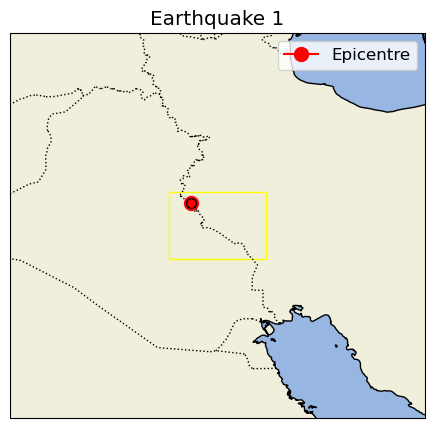

In [10]:
#EARTHQUAKE 1
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
#bbox_coords1 = [(47.716835, 31.984529), (45.073318, 32.38702), (45.406967, 34.067097), (48.103607, 33.666805)]
bbox_coords2 =[(47.715778, 31.983189), (45.07235, 32.385632), (45.40601, 34.065964), (48.102566, 33.665718)]
# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax



xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])


# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[0]
epicenter_lon = df_earthquake['longitude'].iloc[0]
#print(epicenter_lat, epicenter_lon)

# Creare una figura e una proiezione cartografica
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Aggiungere caratteristiche della terra
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Aggiungere il rettangolo del bbox
#rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1,linewidth=1, edgecolor='green', facecolor='none')

# Aggiungere il rettangolo del bbox
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2,
                 linewidth=1, edgecolor='yellow', facecolor='none')


#ax.add_patch(rect1)
ax.add_patch(rect2)


# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=50, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentre')

#add legend
plt.legend()

plt.title('Earthquake 1')

# Visualizzare la mappa
plt.show()

In [6]:
def plotBand(product, band, vmin, vmax):
    band = product.getBand(band)
    w = band.getRasterWidth()
    h = band.getRasterHeight()
    print(w, h)
    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)
    band_data.shape = h, w
    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    imgplot = plt.imshow(band_data, cmap=plt.cm.viridis, vmin=vmin, vmax=vmax)
    plt.colorbar()  # Aggiungi una barra dei colori per aiutare a interpretare i valori
    plt.show()

    return imgplot

In [7]:
operator = 'Apply-Orbit-File'

op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)

op_params = op_spi.getOperatorDescriptor().getParameterDescriptors()

for param in op_params:
    print(param.getName(), param.getDefaultValue())

orbitType Sentinel Precise (Auto Download)
polyDegree 3
continueOnFail false


In [8]:
# Define paths to your Sentinel-1 products
# Define paths to your Sentinel-1 products
slc_image_1 = 'Images/Image1/SAR/SLC/2018/01/06/S1A_IW_SLC__1SDV_20180106T025411_20180106T025439_020028_0221F4_0110.zip'
slc_image_2 = 'Images/Image1/SAR/SLC/2018/01/18/S1A_IW_SLC__1SDV_20180118T025410_20180118T025438_020203_022783_6334.zip'

# Load the SLC images from .zip files
master = ProductIO.readProduct(slc_image_1)
slave = ProductIO.readProduct(slc_image_2)


INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.


In [9]:
width = master.getSceneRasterWidth()
print("Width: {} px".format(width))
height = master.getSceneRasterHeight()
print("Height: {} px".format(height))
name = master.getName()
print("Name: {}".format(name))
band_names = master.getBandNames()
print("Band names: {}".format(", ".join(band_names)))

Width: 70852 px
Height: 15150 px
Name: S1A_IW_SLC__1SDV_20180106T025411_20180106T025439_020028_0221F4_0110
Band names: i_IW1_VH, q_IW1_VH, Intensity_IW1_VH, i_IW1_VV, q_IW1_VV, Intensity_IW1_VV, i_IW2_VH, q_IW2_VH, Intensity_IW2_VH, i_IW2_VV, q_IW2_VV, Intensity_IW2_VV, i_IW3_VH, q_IW3_VH, Intensity_IW3_VH, i_IW3_VV, q_IW3_VV, Intensity_IW3_VV


21292 13482


INFO: org.hsqldb.persist.Logger: dataFileCache open start


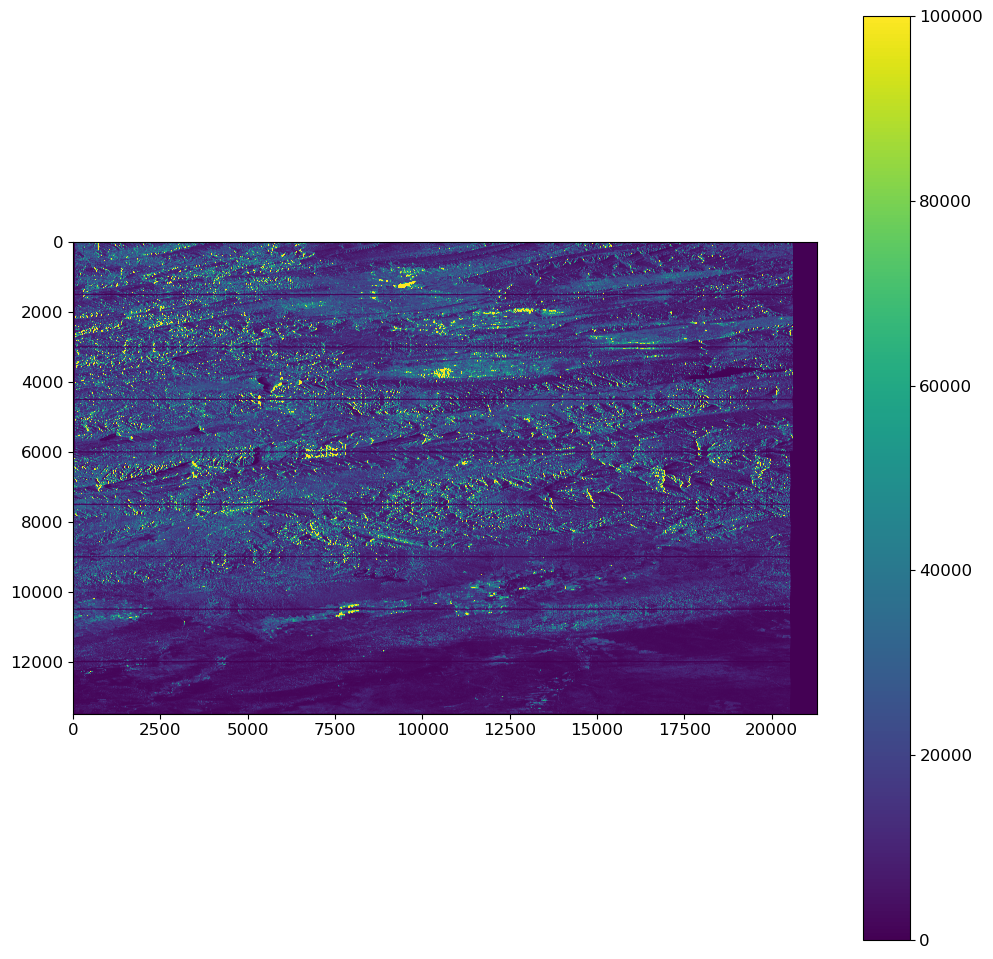

In [7]:
plotBand(master,'Intensity_IW1_VV', 0, 100000)

21291 13482


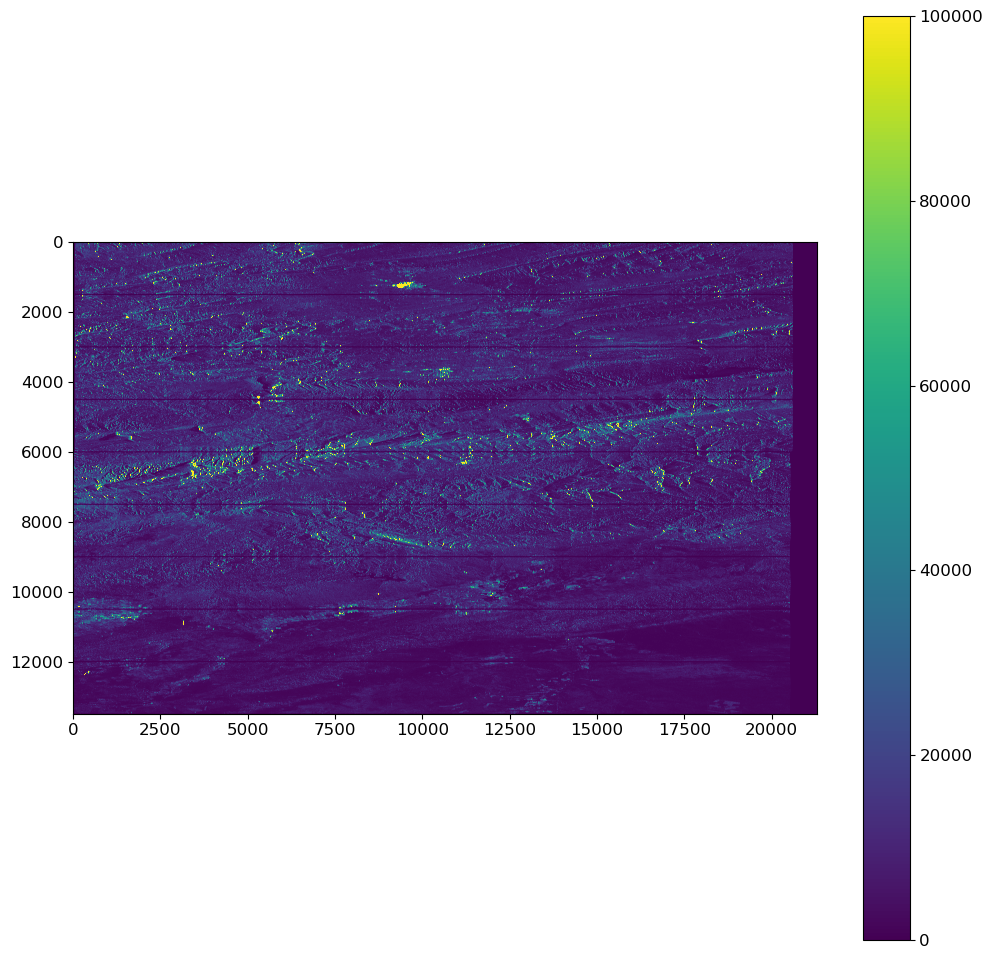

In [14]:
plotBand(slave,'Intensity_IW1_VV', 0, 100000)

In [10]:
parameters = HashMap()

parameters.put('orbitType', 'Sentinel Precise (Auto Download)')
parameters.put('polyDegree', '3')
parameters.put('continueOnFail', 'true')


master_orbit = GPF.createProduct(operator,
                                 parameters, 
                                 master)
    
slave_orbit = GPF.createProduct(operator,
                                 parameters, 
                                 slave)

OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_POEORB AND beginposition:[2018-01-01T00:00:000Z TO 2018-01-31T24:00:000Z]
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2018-01-01T00:00:000Z TO 2018-01-31T24:00:000Z]

100% done.


INFO: org.hsqldb.persist.Logger: dataFileCache open start
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/ebuccoliero/miniforge3/envs/snappp/snap/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2018/01
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/ebuccoliero/miniforge3/envs/snappp/snap/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2018/01
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/ebuccoliero/miniforge3/envs/snappp/snap/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2018/01
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/ebuccoliero/miniforge3/envs/snappp/snap/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2018/01


OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_POEORB AND beginposition:[2018-01-01T00:00:000Z TO 2018-01-31T24:00:000Z]
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2018-01-01T00:00:000Z TO 2018-01-31T24:00:000Z]

100% done.


In [11]:
operator = 'TOPSAR-Split'

op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)

op_params = op_spi.getOperatorDescriptor().getParameterDescriptors()

for param in op_params:
    print(param.getName(), param.getDefaultValue())

subswath None
selectedPolarisations None
firstBurstIndex 1
lastBurstIndex 9999
wktAoi None


In [12]:
slave_split_prds = []
master_split_prds = []

    
parameters = HashMap()

parameters.put('subswath', 'IW1')
parameters.put('selectedPolarisations', 'VV')
parameters.put('firstBurstIndex' , '1')
parameters.put('lastBurstIndex', '9999')

master_split_prds = GPF.createProduct(operator,
                           parameters, 
                           master_orbit)

slave_split_prds = GPF.createProduct(operator,
                           parameters, 
                           slave_orbit)   


100% done.

100% done.


In [13]:
operator = 'Back-Geocoding'

op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)

op_params = op_spi.getOperatorDescriptor().getParameterDescriptors()

for param in op_params:
    print(param.getName(), param.getDefaultValue())

demName SRTM 3Sec
demResamplingMethod BICUBIC_INTERPOLATION
externalDEMFile None
externalDEMNoDataValue 0
resamplingType BISINC_5_POINT_INTERPOLATION
maskOutAreaWithoutElevation true
outputRangeAzimuthOffset false
outputDerampDemodPhase false
disableReramp false


In [14]:
backgeo_prds = []

parameters = HashMap()


for param in op_params:
        parameters.put(param.getName(), param.getDefaultValue())


# Pass master_split_prds and slave_split_prds as separate arguments
backgeo_prds = GPF.createProduct(operator,parameters, 
                           [master_split_prds,   # Assuming you want to use the first item
                           slave_split_prds])   # Assuming you want to use the first item

if backgeo_prds is None:
    print("backgeo_prds is None, something went wrong.")
else:
    print("backgeo_prds created successfully.")



backgeo_prds created successfully.
100% done.


In [15]:
name = backgeo_prds.getName()
print("Name: {}".format(name))
band_names = backgeo_prds.getBandNames()
print("Band names: {}".format(", ".join(band_names)))

Name: S1A_IW_SLC__1SDV_20180118T025410_20180118T025438_020203_022783_6334_Orb_Stack
Band names: i_IW1_VV_mst_18Jan2018, q_IW1_VV_mst_18Jan2018, Intensity_IW1_VV_mst_18Jan2018, i_IW1_VV_slv1_06Jan2018, q_IW1_VV_slv1_06Jan2018, Intensity_IW1_VV_slv1_06Jan2018


In [16]:
operator = 'Interferogram'

op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)

op_params = op_spi.getOperatorDescriptor().getParameterDescriptors()

parameters = HashMap()

for param in op_params:
    print(param.getName(), param.getDefaultValue())
    parameters.put(param.getName(), param.getDefaultValue())

subtractFlatEarthPhase true
srpPolynomialDegree 5
srpNumberPoints 501
orbitDegree 3
includeCoherence true
cohWinAz 10
cohWinRg 10
squarePixel true
subtractTopographicPhase false
demName SRTM 3Sec
externalDEMFile None
externalDEMNoDataValue 0
externalDEMApplyEGM true
tileExtensionPercent 100
outputElevation false
outputLatLon false


In [17]:
interferogram_prds = []

    
params_interferogram = HashMap()


for param in op_params:
        params_interferogram.put(param.getName(), param.getDefaultValue())

interferogram_prds = GPF.createProduct(operator,
                           parameters, 
                           backgeo_prds)

if interferogram_prds is None:
    print("interferogram_prds is None, something went wrong.")
else:
    print("interferogram_prds created successfully.")

band_names = interferogram_prds.getBandNames()
print("Band names: {}".format(", ".join(band_names)))


interferogram_prds created successfully.
Band names: i_ifg_IW1_VV_18Jan2018_06Jan2018, q_ifg_IW1_VV_18Jan2018_06Jan2018, Intensity_ifg_IW1_VV_18Jan2018_06Jan2018, Phase_ifg_IW1_VV_18Jan2018_06Jan2018, coh_IW1_VV_18Jan2018_06Jan2018
100% done.


In [ ]:
band = interferogram_prds.getBand('Phase_ifg_IW1_VV_18Jan2018_06Jan2018')
if band is None:
    print("Band not found.")
else:
    w = band.getRasterWidth()
    h = band.getRasterHeight()
    print(f"Width: {w}, Height: {h}")
    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)
    print("Max value in band:", np.max(band_data))
    print("Min value in band:", np.min(band_data))

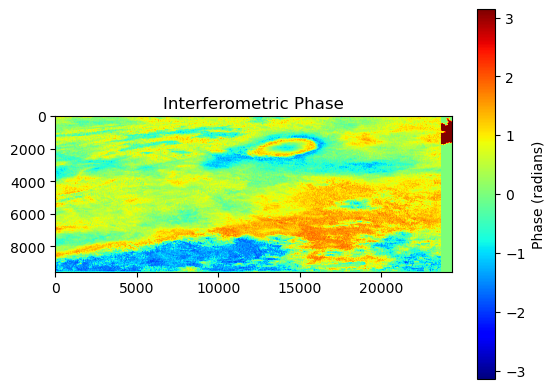

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

# Esempio di caricamento dei dati da file HDF5 (assumendo formato HDF5)
with h5py.File('Images/Image1/Interferogram.h5', 'r') as f:
    i_ifg = f['bands/i_ifg_VV_06Jan2018_18Jan2018'][:]  # Carica la parte reale
    q_ifg = f['bands/q_ifg_VV_06Jan2018_18Jan2018'][:]  # Carica la parte immaginaria

# Calcolo della fase usando la funzione atan2
phase = np.arctan2(q_ifg, i_ifg)

# Ora la variabile 'phase' contiene la fase interferometrica in radianti

plt.imshow(phase, cmap='jet')
plt.colorbar(label='Phase (radians)')
plt.title('Interferometric Phase')
plt.show()

<KeysViewHDF5 ['coh_IW3_VV_06Jan2018_18Jan2018', 'i_ifg_IW3_VV_06Jan2018_18Jan2018', 'q_ifg_IW3_VV_06Jan2018_18Jan2018']>
(12120, 24354)


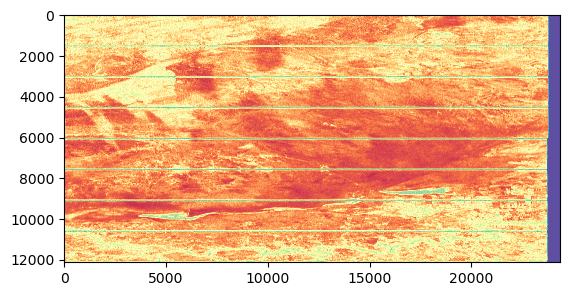

In [2]:
import h5py
import matplotlib.pyplot as plt

with h5py.File("Images/S1A_IW_SLC__1SDV_20180106T025411_20180106T025439_020028_0221F4_0110_Orb_Stack_Ifg.h5") as f:
    print(f['bands'].keys())
    matrix = f['bands/coh_IW3_VV_06Jan2018_18Jan2018'][...]

print(matrix.shape)
plt.imshow(matrix, cmap="Spectral_r")

In [18]:
operator = 'TOPSAR-Deburst'

op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)

op_params = op_spi.getOperatorDescriptor().getParameterDescriptors()

for param in op_params:
    print(param.getName(), param.getDefaultValue())

selectedPolarisations None


In [19]:
deburst_prds = []
 
parameters = HashMap()
parameters.put('selectedPolarisations', 'VV')

deburst_prds=GPF.createProduct(operator,
                           parameters, 
                           interferogram_prds)


100% done.


In [20]:
operator = 'TopoPhaseRemoval'

op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)

op_params = op_spi.getOperatorDescriptor().getParameterDescriptors()

for param in op_params:
    print(param.getName(), param.getDefaultValue())

orbitDegree 3
demName SRTM 3Sec
externalDEMFile None
externalDEMNoDataValue 0
tileExtensionPercent 100
outputTopoPhaseBand false
outputElevationBand false
outputLatLonBands false


(9565, 24352)


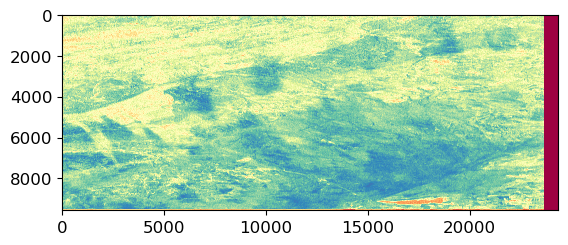

In [10]:
import h5py
import matplotlib.pyplot as plt

with h5py.File("Images/Image1/Interferogram.h5") as f:
    matrix = f['bands/coh_IW3_VV_06Jan2018_18Jan2018'][...]

print(matrix.shape)
plt.imshow(matrix, cmap="Spectral")

<KeysViewHDF5 ['coh_IW3_VV_06Jan2018_18Jan2018', 'i_ifg_VV_06Jan2018_18Jan2018', 'q_ifg_VV_06Jan2018_18Jan2018']>
(12249, 4058)


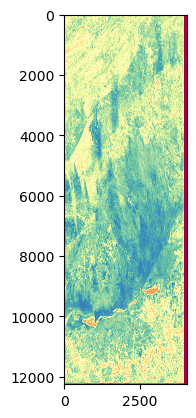

In [4]:
import h5py
import matplotlib.pyplot as plt

with h5py.File("Images/Image1/Interferogram_2.h5") as f:
    print(f['bands'].keys())
    matrix = f['bands/coh_IW3_VV_06Jan2018_18Jan2018'][...]

print(matrix.shape)
plt.imshow(matrix, cmap="Spectral")

<KeysViewHDF5 ['coh_IW3_VV_06Jan2018_18Jan2018', 'i_ifg_VV_06Jan2018_18Jan2018', 'q_ifg_VV_06Jan2018_18Jan2018']>
(12249, 4058)


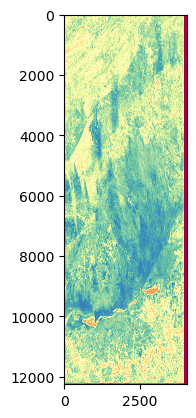

In [15]:
import h5py
import matplotlib.pyplot as plt

with h5py.File("Images/Image1/Interferogram_withoutTerrainCorrection.h5") as f:
    print(f['bands'].keys())
    matrix = f['bands/coh_IW3_VV_06Jan2018_18Jan2018'][...]

print(matrix.shape)
plt.imshow(matrix, cmap="Spectral")

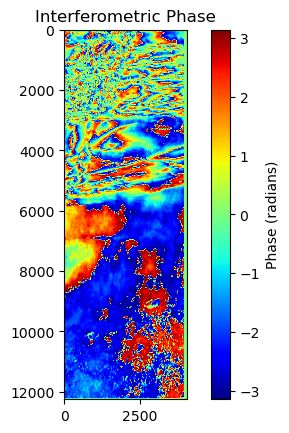

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

# Esempio di caricamento dei dati da file HDF5 (assumendo formato HDF5)
with h5py.File('Images/Image1/Interferogram_withoutTerrainCorrection.h5', 'r') as f:
    i_ifg = f['bands/i_ifg_VV_06Jan2018_18Jan2018'][:]  # Carica la parte reale
    q_ifg = f['bands/q_ifg_VV_06Jan2018_18Jan2018'][:]  # Carica la parte immaginaria

# Calcolo della fase usando la funzione atan2
phase = np.arctan2(q_ifg, i_ifg)

# Ora la variabile 'phase' contiene la fase interferometrica in radianti

plt.imshow(phase, cmap='jet')
plt.colorbar(label='Phase (radians)')
plt.title('Interferometric Phase')
plt.show()

<KeysViewHDF5 ['coh_IW3_VV_06Jan2018_18Jan2018', 'i_ifg_IW3_VV_06Jan2018_18Jan2018', 'q_ifg_IW3_VV_06Jan2018_18Jan2018']>
(6879, 24352)


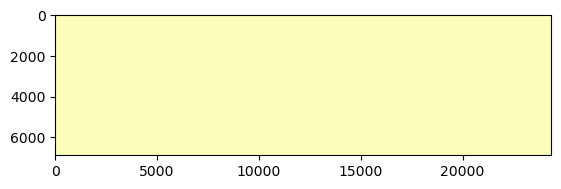

In [2]:
import h5py
import matplotlib.pyplot as plt

with h5py.File("Images/Image1/Inter_withoutTerrain.h5") as f:
    print(f['bands'].keys())
    matrix = f['bands/coh_IW3_VV_06Jan2018_18Jan2018'][...]

print(matrix.shape)
plt.imshow(matrix, cmap="Spectral")

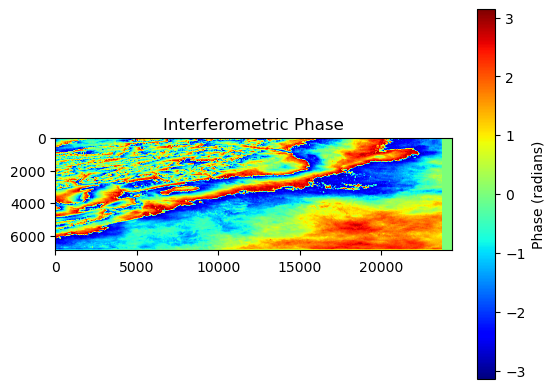

In [2]:
import numpy as np
import h5py

# Esempio di caricamento dei dati da file HDF5 (assumendo formato HDF5)
with h5py.File('Images/Image1/Inter_withALL.h5', 'r') as f:
    i_ifg = f['bands/i_ifg_IW3_VV_06Jan2018_18Jan2018'][:]  # Carica la parte reale
    q_ifg = f['bands/q_ifg_IW3_VV_06Jan2018_18Jan2018'][:]  # Carica la parte immaginaria

# Calcolo della fase usando la funzione atan2
phase = np.arctan2(q_ifg, i_ifg)

# Ora la variabile 'phase' contiene la fase interferometrica in radianti
import matplotlib.pyplot as plt

plt.imshow(phase, cmap='jet')
plt.colorbar(label='Phase (radians)')
plt.title('Interferometric Phase')
plt.show()

In [25]:
import numpy as np
import h5py

# Esempio di caricamento dei dati da file HDF5 (assumendo formato HDF5)
with h5py.File('Images/Image1/Interferogram_noDebrust.h5', 'r') as f:
    i_ifg = f['bands/i_ifg_IW3_VV_06Jan2018_18Jan2018'][:]  # Carica la parte reale
    q_ifg = f['bands/q_ifg_IW3_VV_06Jan2018_18Jan2018'][:]  # Carica la parte immaginaria

# Calcolo della fase usando la funzione atan2
phase = np.arctan2(q_ifg, i_ifg)

# Ora la variabile 'phase' contiene la fase interferometrica in radianti
import matplotlib.pyplot as plt
print(phase.shape())
plt.imshow(phase, cmap='jet')
plt.colorbar(label='Phase (radians)')
plt.title('Interferometric Phase without Debrust')
plt.show()

TypeError: 'tuple' object is not callable

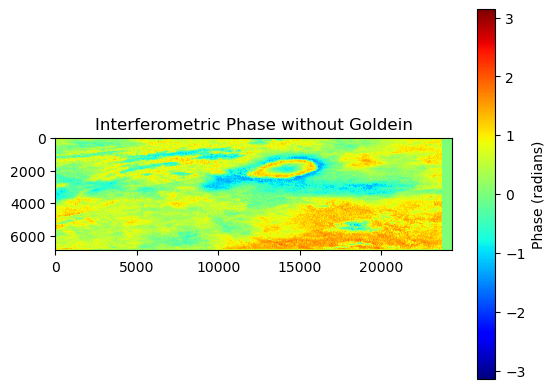

In [5]:
import numpy as np
import h5py

# Esempio di caricamento dei dati da file HDF5 (assumendo formato HDF5)
with h5py.File('Images/Image1/Interferogram_noGoldein.h5', 'r') as f:
    i_ifg = f['bands/i_ifg_IW3_VV_06Jan2018_18Jan2018'][:]  # Carica la parte reale
    q_ifg = f['bands/q_ifg_IW3_VV_06Jan2018_18Jan2018'][:]  # Carica la parte immaginaria

# Calcolo della fase usando la funzione atan2
phase = np.arctan2(q_ifg, i_ifg)

# Ora la variabile 'phase' contiene la fase interferometrica in radianti
import matplotlib.pyplot as plt

plt.imshow(phase, cmap='jet')
plt.colorbar(label='Phase (radians)')
plt.title('Interferometric Phase without Goldein')
plt.show()

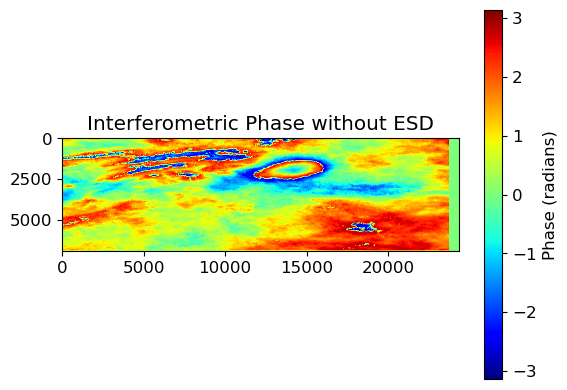

In [15]:
import numpy as np
import h5py

# Esempio di caricamento dei dati da file HDF5 (assumendo formato HDF5)
with h5py.File('Images/Image1/Interferogram_CompleteNOESD.h5', 'r') as f:
    i_ifg = f['bands/i_ifg_IW3_VV_06Jan2018_18Jan2018'][:]  # Carica la parte reale
    q_ifg = f['bands/q_ifg_IW3_VV_06Jan2018_18Jan2018'][:]  # Carica la parte immaginaria

# Calcolo della fase usando la funzione atan2
phase = np.arctan2(q_ifg, i_ifg)

# Ora la variabile 'phase' contiene la fase interferometrica in radianti
import matplotlib.pyplot as plt

plt.imshow(phase, cmap='jet')
plt.colorbar(label='Phase (radians)')
plt.title('Interferometric Phase without ESD')
plt.show()

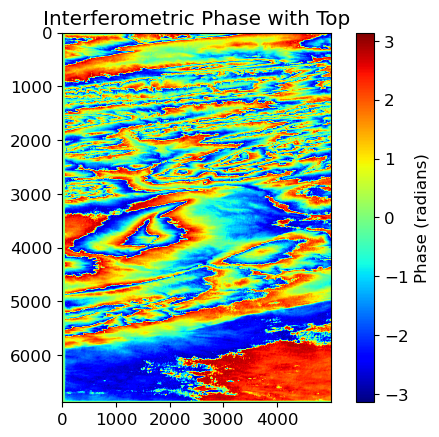

In [29]:
import numpy as np
import h5py

# Esempio di caricamento dei dati da file HDF5 (assumendo formato HDF5)
with h5py.File('Images/Image1/Interf_noESD_TopoPhaseRemoval.h5', 'r') as f:
    #print(f['bands'].keys())
    i_ifg = f['bands/i_ifg_VV_06Jan2018_18Jan2018'][:]  # Carica la parte reale
    q_ifg = f['bands/q_ifg_VV_06Jan2018_18Jan2018'][:]  # Carica la parte immaginaria

# Calcolo della fase usando la funzione atan2
phase = np.arctan2(q_ifg, i_ifg)

# Ora la variabile 'phase' contiene la fase interferometrica in radianti
import matplotlib.pyplot as plt

plt.imshow(phase[0:10000,0:5000], cmap='jet')
plt.colorbar(label='Phase (radians)')
plt.title('Interferometric Phase with Top')
plt.show()

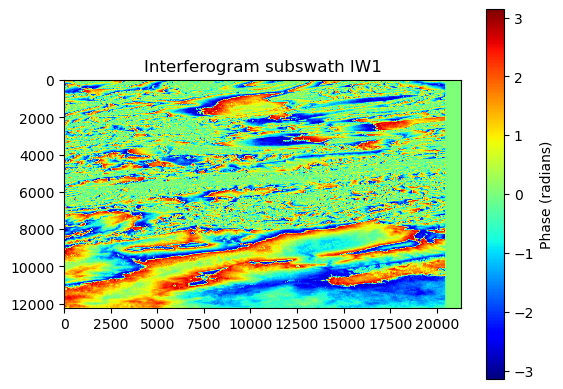

In [7]:
import numpy as np
import h5py

# Esempio di caricamento dei dati da file HDF5 (assumendo formato HDF5)
with h5py.File('Images/Image1/Interferogram_IW1.h5', 'r') as f:
    #print(f['bands'].keys())
    i_ifg = f['bands/i_ifg_VV_06Jan2018_18Jan2018'][:]  # Carica la parte reale
    q_ifg = f['bands/q_ifg_VV_06Jan2018_18Jan2018'][:]  # Carica la parte immaginaria

# Calcolo della fase usando la funzione atan2
phase = np.arctan2(q_ifg, i_ifg)

# Ora la variabile 'phase' contiene la fase interferometrica in radianti
import matplotlib.pyplot as plt

plt.imshow(phase, cmap='jet')
plt.colorbar(label='Phase (radians)')
plt.title('Interferogram subswath IW1')
plt.show()

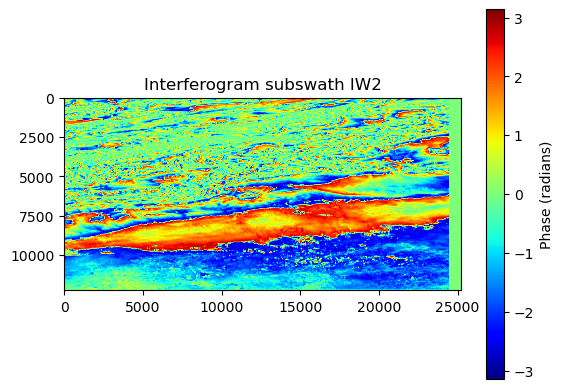

In [8]:
import numpy as np
import h5py

# Esempio di caricamento dei dati da file HDF5 (assumendo formato HDF5)
with h5py.File('Images/Image1/Interferogram_IW2.h5', 'r') as f:
    #print(f['bands'].keys())
    i_ifg = f['bands/i_ifg_VV_06Jan2018_18Jan2018'][:]  # Carica la parte reale
    q_ifg = f['bands/q_ifg_VV_06Jan2018_18Jan2018'][:]  # Carica la parte immaginaria

# Calcolo della fase usando la funzione atan2
phase = np.arctan2(q_ifg, i_ifg)

# Ora la variabile 'phase' contiene la fase interferometrica in radianti
import matplotlib.pyplot as plt

plt.imshow(phase, cmap='jet')
plt.colorbar(label='Phase (radians)')
plt.title('Interferogram subswath IW2')
plt.show()

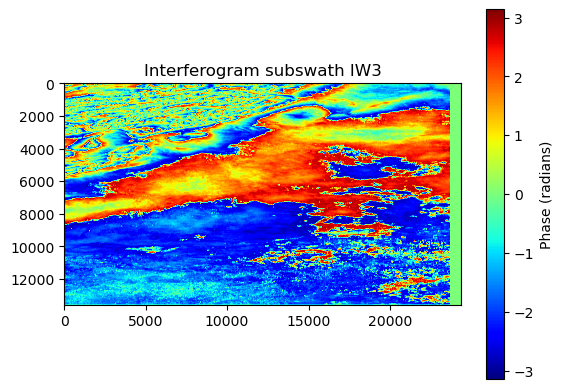

In [9]:
import numpy as np
import h5py

# Esempio di caricamento dei dati da file HDF5 (assumendo formato HDF5)
with h5py.File('Images/Image1/Interferogram_IW3.h5', 'r') as f:
    #print(f['bands'].keys())
    i_ifg = f['bands/i_ifg_VV_06Jan2018_18Jan2018'][:]  # Carica la parte reale
    q_ifg = f['bands/q_ifg_VV_06Jan2018_18Jan2018'][:]  # Carica la parte immaginaria

# Calcolo della fase usando la funzione atan2
phase = np.arctan2(q_ifg, i_ifg)

# Ora la variabile 'phase' contiene la fase interferometrica in radianti
import matplotlib.pyplot as plt

plt.imshow(phase, cmap='jet')
plt.colorbar(label='Phase (radians)')
plt.title('Interferogram subswath IW3')
plt.show()

In [19]:
def listParams(operator_name):
    GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()
    op_spi =GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator_name)
    print('Op name:', op_spi.getOperatorDescriptor().getName())
    print('Op alias: ', op_spi.getOperatorDescriptor().getAlias())
    param_Desc = op_spi.getOperatorDescriptor().getParameterDescriptors()
    for param in param_Desc:
        print(param.getName(), "or", param.getAlias())
    
listParams("Read")

Op name: org.esa.snap.core.gpf.common.ReadOp
Op alias:  Read
file or None
formatName or None
bandNames or sourceBands
maskNames or sourceMasks
pixelRegion or None
geometryRegion or None
copyMetadata or None


# Earthquake 2

In [10]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[1])
print(df_earthquake['image_ids_after'].iloc[1])

S1A_IW_SLC__1SDV_20180110T145938_20180110T150005_020094_022416_45C5
S1A_IW_SLC__1SDV_20180122T145937_20180122T150004_020269_0229A4_A4C8


In [11]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180110T145938_20180110T150005_020094_022416_45C5')

# create an S1Scene instance
s2 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180122T145937_20180122T150004_020269_0229A4_A4C8')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image2')

#s1.download(new_path)
#s2.download(new_path)

 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180110T145938_20180110T150005_020094_022416_45C5
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180110
 Start Time:              145938
 Stop Time:               150005
 Absolute Orbit:          020094
 Relative Orbit:          72
 -------------------------------------------------
 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180122T145937_20180122T150004_020269_0229A4_A4C8
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180122
 Start Time:              145937
 Stop Time:               150004
 Absolute Orb

In [12]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image2/SAR/SLC/2018/01/10/S1A_IW_SLC__1SDV_20180110T145938_20180110T150005_020094_022416_45C5.zip'
name2 = 'Images/Image2/SAR/SLC/2018/01/22/S1A_IW_SLC__1SDV_20180122T145937_20180122T150004_020269_0229A4_A4C8.zip'
scene2_1 = identify(name1)
scene2_2 = identify(name2)
print("SCENE 2_1:\n",scene2_1)
print("\n")
print("SCENE 2_2:\n",scene2_2)

SCENE 2_1:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
coordinates: [(43.730179, 33.574856), (46.451523, 33.980045), (46.77499, 32.352318), (44.105534, 31.945017)]
cycleNumber: 129
frameNumber: 140310
lines: 40554
orbit: A
orbitNumber_abs: 20094
orbitNumber_rel: 72
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 71968
sensor: S1A
spacing: (2.329562, 13.94616)
start: 20180110T145938
stop: 20180110T150005


SCENE 2_2:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
coordinates: [(43.729729, 33.57486), (46.451046, 33.980049), (46.774567, 32.352074), (44.105145, 31.944773)]
cycleNumber: 130
frameNumber: 141732
lines: 40554
orbit: A
orbitNumber_abs: 20269
orbitNumber_rel: 72
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 71968
sensor: S1A
spacing: (2.329562, 13.94617)
start: 20180122T145937
stop: 20180122T150004


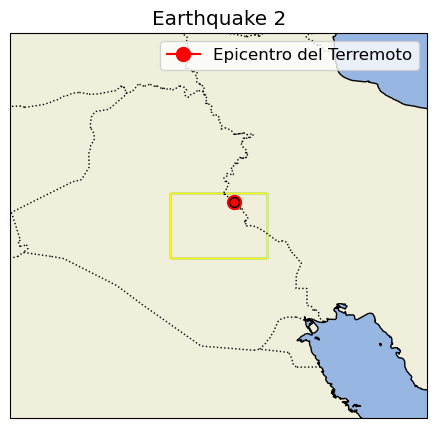

In [22]:
#EARTHQUAKE 2
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = [(43.730179, 33.574856), (46.451523, 33.980045), (46.77499, 32.352318), (44.105534, 31.945017)]
bbox_coords2 =[(43.729729, 33.57486), (46.451046, 33.980049), (46.774567, 32.352074), (44.105145, 31.944773)]
# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])


xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])


# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[1]
epicenter_lon = df_earthquake['longitude'].iloc[1]
#print(epicenter_lat, epicenter_lon)

# Creare una figura e una proiezione cartografica
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Aggiungere caratteristiche della terra
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Aggiungere il rettangolo del bbox
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1,
                 linewidth=1, edgecolor='green', facecolor='none')

# Aggiungere il rettangolo del bbox
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2,
                 linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=50, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

#add legend
plt.legend()

plt.title('Earthquake 2')

# Visualizzare la mappa
plt.show()

# Earthquake 3

In [14]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[2])
print(df_earthquake['image_ids_after'].iloc[2])

S1A_IW_SLC__1SDV_20180103T114629_20180103T114656_019990_0220CB_F384
S1A_IW_SLC__1SDV_20180115T114629_20180115T114656_020165_022657_6FED


In [15]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180103T114629_20180103T114656_019990_0220CB_F384')

# create an S1Scene instance
s2 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180115T114629_20180115T114656_020165_022657_6FED')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image3')

#s1.download(new_path)
#s2.download(new_path)

 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180103T114629_20180103T114656_019990_0220CB_F384
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180103
 Start Time:              114629
 Stop Time:               114656
 Absolute Orbit:          019990
 Relative Orbit:          143
 -------------------------------------------------
 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180115T114629_20180115T114656_020165_022657_6FED
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180115
 Start Time:              114629
 Stop Time:               114656
 Absolute Or

In [16]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image3/SAR/SLC/2018/01/03/S1A_IW_SLC__1SDV_20180103T114629_20180103T114656_019990_0220CB_F384.zip'
name2 = 'Images/Image3/SAR/SLC/2018/01/15/S1A_IW_SLC__1SDV_20180115T114629_20180115T114656_020165_022657_6FED.zip'
scene3_1 = identify(name1)
scene3_2 = identify(name2)
print("SCENE 3_1:\n",scene3_1)
print("\n")
print("SCENE 3_2:\n",scene3_2)

SCENE 3_1:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
coordinates: [(94.126144, 19.501059), (96.520279, 19.931551), (96.835266, 18.30657), (94.465393, 17.872437)]
cycleNumber: 128
frameNumber: 139467
lines: 40608
orbit: A
orbitNumber_abs: 19990
orbitNumber_rel: 143
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 72726
sensor: S1A
spacing: (2.329562, 13.98607)
start: 20180103T114629
stop: 20180103T114656


SCENE 3_2:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
coordinates: [(94.125488, 19.501682), (96.519592, 19.932171), (96.834656, 18.306816), (94.464828, 17.872686)]
cycleNumber: 129
frameNumber: 140887
lines: 40608
orbit: A
orbitNumber_abs: 20165
orbitNumber_rel: 143
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 72725
sensor: S1A
spacing: (2.329562, 13.98608)
start: 20180115T114629
stop: 20180115T114656


Epicenter latitude: 18.3513, longitude: 95.9959
Bounding box 1: xmin=94.126144, xmax=96.835266, ymin=17.872437, ymax=19.931551
Bounding box 2: xmin=94.125488, xmax=96.834656, ymin=17.872686, ymax=19.932171


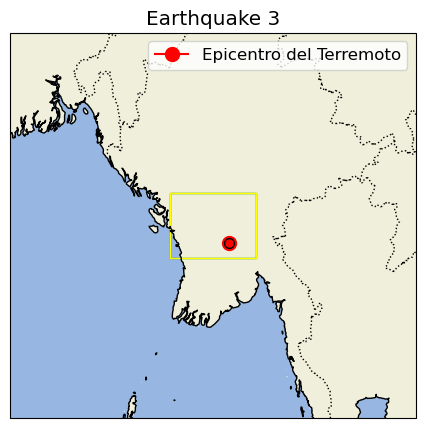

In [23]:
#EARTHQUAKE 3
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = [(94.126144, 19.501059), (96.520279, 19.931551), (96.835266, 18.30657), (94.465393, 17.872437)]
bbox_coords2 = [(94.125488, 19.501682), (96.519592, 19.932171), (96.834656, 18.306816), (94.464828, 17.872686)]

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[2]
epicenter_lon = df_earthquake['longitude'].iloc[2]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=50, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 3')

# Visualizzare la mappa
plt.show()


# Earthquake 4

In [22]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[3])
print(df_earthquake['image_ids_after'].iloc[3])

S1A_IW_SLC__1SDV_20180114T132118_20180114T132145_020151_0225F3_53F5
S1A_IW_SLC__1SDV_20180126T132118_20180126T132145_020326_022B7D_D29E


In [23]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180114T132118_20180114T132145_020151_0225F3_53F5')

# create an S1Scene instance
s2 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180126T132118_20180126T132145_020326_022B7D_D29E')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image4')

#s1.download(new_path)
#s2.download(new_path)

 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180114T132118_20180114T132145_020151_0225F3_53F5
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180114
 Start Time:              132118
 Stop Time:               132145
 Absolute Orbit:          020151
 Relative Orbit:          129
 -------------------------------------------------
 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180126T132118_20180126T132145_020326_022B7D_D29E
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180126
 Start Time:              132118
 Stop Time:               132145
 Absolute Or

In [24]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image4/SAR/SLC/2018/01/14/S1A_IW_SLC__1SDV_20180114T132118_20180114T132145_020151_0225F3_53F5.zip'
name2 = 'Images/Image4/SAR/SLC/2018/01/26/S1A_IW_SLC__1SDV_20180126T132118_20180126T132145_020326_022B7D_D29E.zip'
scene4_1 = identify(name1)
scene4_2 = identify(name2)
print("SCENE 4_1:\n",scene4_1)
print("\n")
print("SCENE 4_2:\n",scene4_2)

SCENE 4_1:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
cycleNumber: 129
frameNumber: 140787
lines: 40761
orbit: D
orbitNumber_abs: 20151
orbitNumber_rel: 129
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 72616
sensor: S1A
spacing: (2.329562, 13.96392)
start: 20180114T132118
stop: 20180114T132145


SCENE 4_2:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
cycleNumber: 130
frameNumber: 142205
lines: 40761
orbit: D
orbitNumber_abs: 20326
orbitNumber_rel: 129
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 72616
sensor: S1A
spacing: (2.329562, 13.96395)
start: 20180126T132118
stop: 20180126T132145


Epicenter latitude: 26.6196, longitude: -110.9457
Bounding box 1: xmin=-112.499832, xmax=-109.634277, ymin=25.679638, ymax=27.728321
Bounding box 2: xmin=-112.499077, xmax=-109.633492, ymin=25.679216, ymax=27.728075


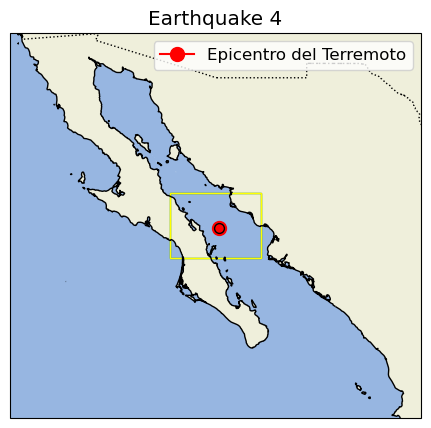

In [28]:
#EARTHQUAKE 4
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = [(-109.989349, 25.679638), (-112.499832, 26.097631), (-112.182777, 27.728321), (-109.634277, 27.313227)]
bbox_coords2 = [(-109.988632, 25.679216), (-112.499077, 26.097261), (-112.181953, 27.728075), (-109.633492, 27.312927)]

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[3]
epicenter_lon = df_earthquake['longitude'].iloc[3]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=50, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 4')

# Visualizzare la mappa
plt.show()


# Earthquake 5

In [2]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[4])
print(df_earthquake['image_ids_after'].iloc[4])

S1A_IW_SLC__1SDV_20180115T173156_20180115T173226_020168_022672_7B3F
S1A_IW_SLC__1SDV_20180127T173156_20180127T173226_020343_022BFD_0DD1


In [3]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180115T173156_20180115T173226_020168_022672_7B3F')

# create an S1Scene instance
s2 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180127T173156_20180127T173226_020343_022BFD_0DD1')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image5')

#s1.download(new_path)
#s2.download(new_path)

 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180115T173156_20180115T173226_020168_022672_7B3F
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180115
 Start Time:              173156
 Stop Time:               173226
 Absolute Orbit:          020168
 Relative Orbit:          146
 -------------------------------------------------
 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180127T173156_20180127T173226_020343_022BFD_0DD1
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180127
 Start Time:              173156
 Stop Time:               173226
 Absolute Or

In [4]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image5/SAR/SLC/2018/01/15/S1A_IW_SLC__1SDV_20180115T173156_20180115T173226_020168_022672_7B3F.zip'
name2 = 'Images/Image5/SAR/SLC/2018/01/27/S1A_IW_SLC__1SDV_20180127T173156_20180127T173226_020343_022BFD_0DD1.zip'
scene5_1 = identify(name1)
scene5_2 = identify(name2)
print("SCENE 5_1:\n",scene5_1)
print("\n")
print("SCENE 5_2:\n",scene5_2)

SCENE 5_1:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
cycleNumber: 129
frameNumber: 140914
lines: 44890
orbit: D
orbitNumber_abs: 20168
orbitNumber_rel: 146
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 68494
sensor: S1A
spacing: (2.329562, 14.05815)
start: 20180115T173156
stop: 20180115T173226


SCENE 5_2:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
cycleNumber: 130
frameNumber: 142333
lines: 44890
orbit: D
orbitNumber_abs: 20343
orbitNumber_rel: 146
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 68496
sensor: S1A
spacing: (2.329562, 14.05817)
start: 20180127T173156
stop: 20180127T173226


Epicenter latitude: -17.8051, longitude: -179.5737
Bounding box 1: xmin=-179.064392, xmax=179.084167, ymin=-18.015673, ymax=-15.688534
Bounding box 2: xmin=-179.06395, xmax=179.084412, ymin=-18.013924, ymax=-15.687607


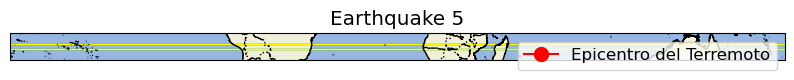

In [5]:
#EARTHQUAKE 5
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = [(-179.064392, -18.015673), (178.629532, -17.477215), (179.084167, -15.688534), (-178.633133, -16.218725)]
bbox_coords2 = [(-179.06395, -18.013924), (178.629959, -17.475422), (179.084412, -15.687607), (-178.632874, -16.217846)]

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[4]
epicenter_lon = df_earthquake['longitude'].iloc[4]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Aggiungere il rettangolo del bbox
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1,
                 linewidth=1, edgecolor='green', facecolor='none')

# Aggiungere il rettangolo del bbox
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2,
                 linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=20, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 5')

# Visualizzare la mappa
plt.show()

# Earthquake 6

In [6]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[5])
print(df_earthquake['image_ids_after'].iloc[5])

S1A_IW_SLC__1SDV_20180129T131330_20180129T131357_020370_022CCB_4394
S1A_IW_SLC__1SDV_20180210T131330_20180210T131357_020545_023268_A7EE


In [7]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180129T131330_20180129T131357_020370_022CCB_4394')

# create an S1Scene instance
s2 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180210T131330_20180210T131357_020545_023268_A7EE')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image6')

#s1.download(new_path)
#s2.download(new_path)

 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180129T131330_20180129T131357_020370_022CCB_4394
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180129
 Start Time:              131330
 Stop Time:               131357
 Absolute Orbit:          020370
 Relative Orbit:          173
 -------------------------------------------------
 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180210T131330_20180210T131357_020545_023268_A7EE
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180210
 Start Time:              131330
 Stop Time:               131357
 Absolute Or

In [8]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image6/SAR/SLC/2018/01/29/S1A_IW_SLC__1SDV_20180129T131330_20180129T131357_020370_022CCB_4394.zip'
name2 = 'Images/Image6/SAR/SLC/2018/02/10/S1A_IW_SLC__1SDV_20180210T131330_20180210T131357_020545_023268_A7EE.zip'
scene6_1 = identify(name1)
scene6_2 = identify(name2)
print("SCENE 6_1:\n",scene6_1)
print("\n")
print("SCENE 6_2:\n",scene6_2)

SCENE 6_1:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
cycleNumber: 130
frameNumber: 142539
lines: 40617
orbit: A
orbitNumber_abs: 20370
orbitNumber_rel: 173
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 71139
sensor: S1A
spacing: (2.329562, 13.94324)
start: 20180129T131330
stop: 20180129T131357


SCENE 6_2:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
cycleNumber: 131
frameNumber: 143976
lines: 40617
orbit: A
orbitNumber_abs: 20545
orbitNumber_rel: 173
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 71138
sensor: S1A
spacing: (2.329562, 13.94325)
start: 20180210T131330
stop: 20180210T131357


In [9]:
#EARTHQUAKE 6
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[5]
epicenter_lon = df_earthquake['longitude'].iloc[5]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=50, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 6')

# Visualizzare la mappa
plt.show()

ValueError: min() arg is an empty sequence

# Earthquake 7

In [10]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[6])
print(df_earthquake['image_ids_after'].iloc[6])

S1A_IW_SLC__1SDV_20180112T215202_20180112T215232_020127_022520_AC94
S1A_IW_SLC__1SDV_20180205T215202_20180205T215231_020477_023046_97B4


In [11]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180112T215202_20180112T215232_020127_022520_AC94')

# create an S1Scene instance
s2 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180205T215202_20180205T215231_020477_023046_97B4')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image7')

#s1.download(new_path)
#s2.download(new_path)

 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180112T215202_20180112T215232_020127_022520_AC94
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180112
 Start Time:              215202
 Stop Time:               215232
 Absolute Orbit:          020127
 Relative Orbit:          105
 -------------------------------------------------
 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180205T215202_20180205T215231_020477_023046_97B4
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180205
 Start Time:              215202
 Stop Time:               215231
 Absolute Or

In [12]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image7/SAR/SLC/2018/01/12/S1A_IW_SLC__1SDV_20180112T215202_20180112T215232_020127_022520_AC94.zip'
name2 = 'Images/Image7/SAR/SLC/2018/02/05/S1A_IW_SLC__1SDV_20180205T215202_20180205T215231_020477_023046_97B4.zip'
scene7_1 = identify(name1)
scene7_2 = identify(name2)
print("SCENE 7_1:\n",scene7_1)
print("\n")
print("SCENE 7_2:\n",scene7_2)

SCENE 7_1:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
cycleNumber: 129
frameNumber: 140576
lines: 45010
orbit: D
orbitNumber_abs: 20127
orbitNumber_rel: 105
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 68801
sensor: S1A
spacing: (2.329562, 13.97303)
start: 20180112T215202
stop: 20180112T215232


SCENE 7_2:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
cycleNumber: 131
frameNumber: 143430
lines: 45010
orbit: D
orbitNumber_abs: 20477
orbitNumber_rel: 105
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 68802
sensor: S1A
spacing: (2.329562, 13.97305)
start: 20180205T215202
stop: 20180205T215231


# Earthquake 8

In [13]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[7])
print(df_earthquake['image_ids_after'].iloc[7])

S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8
S1A_IW_SLC__1SDV_20180215T100056_20180215T100124_020616_0234B9_22BC


In [19]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8')

# create an S1Scene instance
s2 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180215T100056_20180215T100124_020616_0234B9_22BC')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image8')

s1.download(new_path)
s2.download(new_path)

INFO:ost.s1.s1scene:One or more of your scenes need to be downloaded.


 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180203
 Start Time:              100056
 Stop Time:               100124
 Absolute Orbit:          020441
 Relative Orbit:          69
 -------------------------------------------------
 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180215T100056_20180215T100124_020616_0234B9_22BC
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180215
 Start Time:              100056
 Stop Time:               100124
 Absolute Orb

 Type 1, 2, 3, or 4:  2


 If you do not have a ASF/NASA Earthdata user account go to: https://search.asf.alaska.edu/ and register


 Your ASF/NASA Earthdata Username: elenabucco
 Your ASF/NASA Earthdata Password: ········


INFO:ost.helpers.asf:S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8 has been already downloaded.


 INFO (18:09:21): S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8 has been already downloaded.


INFO:ost.s1.s1scene:One or more of your scenes need to be downloaded.


 INFO (18:09:21): One or more of your scenes need to be downloaded.
 Select the server from where you want to download:
 (1) Copernicus Apihub (ESA, rolling archive)
 (2) Alaska Satellite Facility (NASA, full archive)
 (3) PEPS (CNES, 1 year rolling archive)
 (4) ONDA DIAS (ONDA DIAS full archive for SLC - or GRD from 30 June 2019)


KeyboardInterrupt: Interrupted by user

In [18]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image8/SAR/SLC/2018/02/03/S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8.zip'
name2 = 'Images/Image8/SAR/SLC/2018/02/15/S1A_IW_SLC__1SDV_20180215T100056_20180215T100124_020616_0234B9_22BC.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 8_1:\n",scene8_1)
print("\n")
print("SCENE 8_2:\n",scene8_2)

OSError: No such file or directory: 'Images/Image8/SAR/SLC/2018/02/03/S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8zip'

In [ ]:
#EARTHQUAKE 8
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[7]
epicenter_lon = df_earthquake['longitude'].iloc[7]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=50, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 8')

# Visualizzare la mappa
plt.show()

# Earthquake 9

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[8])
print(df_earthquake['image_ids_after'].iloc[8)

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image9')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image9/SAR/SLC/2018/zip'
name2 = 'Images/Image9/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 9_1:\n",scene8_1)
print("\n")
print("SCENE 9_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 9
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[8]
epicenter_lon = df_earthquake['longitude'].iloc[8]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=50, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 9')

# Visualizzare la mappa
plt.show()

# Earthquake 10

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[9])
print(df_earthquake['image_ids_after'].iloc[9])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image10')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image10/SAR/SLC/2018/zip'
name2 = 'Images/Image10/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 10_1:\n",scene8_1)
print("\n")
print("SCENE 10_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 10
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[9]
epicenter_lon = df_earthquake['longitude'].iloc[9]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=50, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 10')

# Visualizzare la mappa
plt.show()

# Earthquake 11

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[10])
print(df_earthquake['image_ids_after'].iloc[10])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image11')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image11/SAR/SLC/2018/zip'
name2 = 'Images/Image11/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 11_1:\n",scene8_1)
print("\n")
print("SCENE 11_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 11
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[10]
epicenter_lon = df_earthquake['longitude'].iloc[10]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=50, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 11')

# Visualizzare la mappa
plt.show()

# Earthquake 12

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[11])
print(df_earthquake['image_ids_after'].iloc[11])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image12')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image12/SAR/SLC/2018/zip'
name2 = 'Images/Image12/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 12_1:\n",scene8_1)
print("\n")
print("SCENE 12_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 12
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[11]
epicenter_lon = df_earthquake['longitude'].iloc[11]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 12')

# Visualizzare la mappa
plt.show()

# Earthquake 13

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[12])
print(df_earthquake['image_ids_after'].iloc[12])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image13')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image13/SAR/SLC/2018/zip'
name2 = 'Images/Image13/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 13_1:\n",scene8_1)
print("\n")
print("SCENE 13_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 13
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[12]
epicenter_lon = df_earthquake['longitude'].iloc[12]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 13')

# Visualizzare la mappa
plt.show()

# Earthquake 14

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[13])
print(df_earthquake['image_ids_after'].iloc[13])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image14')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image14/SAR/SLC/2018/zip'
name2 = 'Images/Image14/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 14_1:\n",scene8_1)
print("\n")
print("SCENE 14_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 14
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[13]
epicenter_lon = df_earthquake['longitude'].iloc[13]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 14')

# Visualizzare la mappa
plt.show()

# Earthquake 15

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[14])
print(df_earthquake['image_ids_after'].iloc[14])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image15')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image15/SAR/SLC/2018/zip'
name2 = 'Images/Image15/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 15_1:\n",scene8_1)
print("\n")
print("SCENE 15_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 15
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[14]
epicenter_lon = df_earthquake['longitude'].iloc[14]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 15')

# Visualizzare la mappa
plt.show()

# Earthquake 16

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[15])
print(df_earthquake['image_ids_after'].iloc[15])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image16')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image16/SAR/SLC/2018/zip'
name2 = 'Images/Image16/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 16_1:\n",scene8_1)
print("\n")
print("SCENE 16_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 16
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[15]
epicenter_lon = df_earthquake['longitude'].iloc[15]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 16')

# Visualizzare la mappa
plt.show()

# Earthquake 17

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[16])
print(df_earthquake['image_ids_after'].iloc[16])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image17')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image17/SAR/SLC/2018/zip'
name2 = 'Images/Image17/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 17_1:\n",scene8_1)
print("\n")
print("SCENE 17_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 17
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[16]
epicenter_lon = df_earthquake['longitude'].iloc[16]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 17')

# Visualizzare la mappa
plt.show()

# Earthquake 18

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[17])
print(df_earthquake['image_ids_after'].iloc[17])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image18')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image18/SAR/SLC/2018/zip'
name2 = 'Images/Image18/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 18_1:\n",scene8_1)
print("\n")
print("SCENE 18_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 18
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[17]
epicenter_lon = df_earthquake['longitude'].iloc[17]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 18')

# Visualizzare la mappa
plt.show()

# Earthquake 19

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[18])
print(df_earthquake['image_ids_after'].iloc[18])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image19')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image19/SAR/SLC/2018/zip'
name2 = 'Images/Image19/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 19_1:\n",scene8_1)
print("\n")
print("SCENE 19_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 19
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[18]
epicenter_lon = df_earthquake['longitude'].iloc[18]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 19')

# Visualizzare la mappa
plt.show()

# Earthquake 20

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[19])
print(df_earthquake['image_ids_after'].iloc[19])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image20')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image20/SAR/SLC/2018/zip'
name2 = 'Images/Image20/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 20_1:\n",scene8_1)
print("\n")
print("SCENE 20_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 20
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[19]
epicenter_lon = df_earthquake['longitude'].iloc[19]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 20')

# Visualizzare la mappa
plt.show()

# Earthquake 21

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[20])
print(df_earthquake['image_ids_after'].iloc[20])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image21')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image21/SAR/SLC/2018/zip'
name2 = 'Images/Image21/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 21_1:\n",scene8_1)
print("\n")
print("SCENE 21_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 21
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[20]
epicenter_lon = df_earthquake['longitude'].iloc[20]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 21')

# Visualizzare la mappa
plt.show()

# Earthquake 22

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[21])
print(df_earthquake['image_ids_after'].iloc[21])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image22')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image22/SAR/SLC/2018/zip'
name2 = 'Images/Image22/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 22_1:\n",scene8_1)
print("\n")
print("SCENE 22_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 22
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[21]
epicenter_lon = df_earthquake['longitude'].iloc[21]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 22')

# Visualizzare la mappa
plt.show()

# Earthquake 23

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[22])
print(df_earthquake['image_ids_after'].iloc[22])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image23')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image23/SAR/SLC/2018/zip'
name2 = 'Images/Image23/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 23_1:\n",scene8_1)
print("\n")
print("SCENE 23_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 23
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[22]
epicenter_lon = df_earthquake['longitude'].iloc[22]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 23')

# Visualizzare la mappa
plt.show()

# Earthquake 24

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[23])
print(df_earthquake['image_ids_after'].iloc[23])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image24')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image24/SAR/SLC/2018/zip'
name2 = 'Images/Image24/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 24_1:\n",scene8_1)
print("\n")
print("SCENE 24_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 24
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[23]
epicenter_lon = df_earthquake['longitude'].iloc[23]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 24')

# Visualizzare la mappa
plt.show()

# Earthquake 25

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[24])
print(df_earthquake['image_ids_after'].iloc[24])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image25')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image25/SAR/SLC/2018/zip'
name2 = 'Images/Image25/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 25_1:\n",scene8_1)
print("\n")
print("SCENE 25_2:\n",scene8_2)

In [23]:
#EARTHQUAKE 25
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[24]
epicenter_lon = df_earthquake['longitude'].iloc[24]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 25')

# Visualizzare la mappa
plt.show()

ValueError: min() arg is an empty sequence

# Earthquake 26

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[25])
print(df_earthquake['image_ids_after'].iloc[25])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image26')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image26/SAR/SLC/2018/zip'
name2 = 'Images/Image26/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 26_1:\n",scene8_1)
print("\n")
print("SCENE 26_2:\n",scene8_2)

In [ ]:
#EARTHQUAKE 26
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[25]
epicenter_lon = df_earthquake['longitude'].iloc[25]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 26')

# Visualizzare la mappa
plt.show()

# Earthquake 27

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[26])
print(df_earthquake['image_ids_after'].iloc[26])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image27')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image27/SAR/SLC/2018/zip'
name2 = 'Images/Image27/SAR/SLC/2018/.zip'
scene8_1 = identify(name1)
scene8_2 = identify(name2)
print("SCENE 27_1:\n",scene8_1)
print("\n")
print("SCENE 27_2:\n",scene8_2)

# Earthquake 28

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[27])
print(df_earthquake['image_ids_after'].iloc[27])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image28')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image28/SAR/SLC/2018/zip'
name2 = 'Images/Image28/SAR/SLC/2018/.zip'
scene28_1 = identify(name1)
scene28_2 = identify(name2)
print("SCENE 28_1:\n",scene28_1)
print("\n")
print("SCENE 28_2:\n",scene28_2)

In [ ]:
#EARTHQUAKE 28
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[27]
epicenter_lon = df_earthquake['longitude'].iloc[27]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 28')

# Visualizzare la mappa
plt.show()

# Earthquake 29

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[28])
print(df_earthquake['image_ids_after'].iloc[28])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image29')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image29/SAR/SLC/2018/zip'
name2 = 'Images/Image29/SAR/SLC/2018/.zip'
scene28_1 = identify(name1)
scene28_2 = identify(name2)
print("SCENE 29_1:\n",scene28_1)
print("\n")
print("SCENE 29_2:\n",scene28_2)

In [ ]:
#EARTHQUAKE 29
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[28]
epicenter_lon = df_earthquake['longitude'].iloc[28]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 29')

# Visualizzare la mappa
plt.show()

# Earthquake 30

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[29])
print(df_earthquake['image_ids_after'].iloc[29])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image30')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image30/SAR/SLC/2018/zip'
name2 = 'Images/Image30/SAR/SLC/2018/.zip'
scene28_1 = identify(name1)
scene28_2 = identify(name2)
print("SCENE 30_1:\n",scene28_1)
print("\n")
print("SCENE 30_2:\n",scene28_2)

In [ ]:
#EARTHQUAKE 30
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[29]
epicenter_lon = df_earthquake['longitude'].iloc[29]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 30')

# Visualizzare la mappa
plt.show()

# Earthquake 31

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[30])
print(df_earthquake['image_ids_after'].iloc[30])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image31')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image31/SAR/SLC/2018/zip'
name2 = 'Images/Image31/SAR/SLC/2018/.zip'
scene28_1 = identify(name1)
scene28_2 = identify(name2)
print("SCENE 31_1:\n",scene28_1)
print("\n")
print("SCENE 31_2:\n",scene28_2)

In [ ]:
#EARTHQUAKE 31
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[30]
epicenter_lon = df_earthquake['longitude'].iloc[30]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 31')

# Visualizzare la mappa
plt.show()

# Earthquake 32

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[31])
print(df_earthquake['image_ids_after'].iloc[31])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image32')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image32/SAR/SLC/2018/zip'
name2 = 'Images/Image32/SAR/SLC/2018/.zip'
scene28_1 = identify(name1)
scene28_2 = identify(name2)
print("SCENE 32_1:\n",scene28_1)
print("\n")
print("SCENE 32_2:\n",scene28_2)

In [ ]:
#EARTHQUAKE 32
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[31]
epicenter_lon = df_earthquake['longitude'].iloc[31]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 32')

# Visualizzare la mappa
plt.show()

# Earthquake 33

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[32])
print(df_earthquake['image_ids_after'].iloc[32])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image33')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image33/SAR/SLC/2018/zip'
name2 = 'Images/Image33/SAR/SLC/2018/.zip'
scene28_1 = identify(name1)
scene28_2 = identify(name2)
print("SCENE 33_1:\n",scene28_1)
print("\n")
print("SCENE 33_2:\n",scene28_2)

In [ ]:
#EARTHQUAKE 33
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[32]
epicenter_lon = df_earthquake['longitude'].iloc[32]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 33')

# Visualizzare la mappa
plt.show()

# Earthquake 34

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[33])
print(df_earthquake['image_ids_after'].iloc[33])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image34')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image34/SAR/SLC/2018/zip'
name2 = 'Images/Image34/SAR/SLC/2018/.zip'
scene28_1 = identify(name1)
scene28_2 = identify(name2)
print("SCENE 34_1:\n",scene28_1)
print("\n")
print("SCENE 34_2:\n",scene28_2)

In [ ]:
#EARTHQUAKE 34
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[33]
epicenter_lon = df_earthquake['longitude'].iloc[33]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 34')

# Visualizzare la mappa
plt.show()

# Earthquake 35

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[34])
print(df_earthquake['image_ids_after'].iloc[34])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image35')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image35/SAR/SLC/2018/zip'
name2 = 'Images/Image35/SAR/SLC/2018/.zip'
scene28_1 = identify(name1)
scene28_2 = identify(name2)
print("SCENE 35_1:\n",scene28_1)
print("\n")
print("SCENE 35_2:\n",scene28_2)

In [ ]:
#EARTHQUAKE 35
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[34]
epicenter_lon = df_earthquake['longitude'].iloc[34]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 35')

# Visualizzare la mappa
plt.show()

# Earthquake 36

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[35])
print(df_earthquake['image_ids_after'].iloc[35])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image36')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image36/SAR/SLC/2018/zip'
name2 = 'Images/Image36/SAR/SLC/2018/.zip'
scene28_1 = identify(name1)
scene28_2 = identify(name2)
print("SCENE 36_1:\n",scene28_1)
print("\n")
print("SCENE 36_2:\n",scene28_2)

In [ ]:
#EARTHQUAKE 36
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[35]
epicenter_lon = df_earthquake['longitude'].iloc[35]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 36')

# Visualizzare la mappa
plt.show()

# Earthquake 37

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[36])
print(df_earthquake['image_ids_after'].iloc[36])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image37')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image37/SAR/SLC/2018/zip'
name2 = 'Images/Image37/SAR/SLC/2018/.zip'
scene28_1 = identify(name1)
scene28_2 = identify(name2)
print("SCENE 37_1:\n",scene28_1)
print("\n")
print("SCENE 37_2:\n",scene28_2)

In [ ]:
#EARTHQUAKE 37
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[36]
epicenter_lon = df_earthquake['longitude'].iloc[36]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 37')

# Visualizzare la mappa
plt.show()

# Earthquake 38

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[37])
print(df_earthquake['image_ids_after'].iloc[37])

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image38')

s1.download(new_path)
s2.download(new_path)

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image38/SAR/SLC/2018/zip'
name2 = 'Images/Image38/SAR/SLC/2018/.zip'
scene28_1 = identify(name1)
scene28_2 = identify(name2)
print("SCENE 38_1:\n",scene28_1)
print("\n")
print("SCENE 38_2:\n",scene28_2)

In [ ]:
#EARTHQUAKE 38
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[37]
epicenter_lon = df_earthquake['longitude'].iloc[37]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 38')

# Visualizzare la mappa
plt.show()

# Earthquake 39

In [ ]:
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake['image_ids_before'].iloc[38])
print(df_earthquake['image_ids_after'].iloc[38])

In [5]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('')

# create an S1Scene instance
s2 = Sentinel1Scene('')
                    
# print summarising infos about the scene
s1.info()
s2.info()


# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', 'Image39')

s1.download(new_path)
s2.download(new_path)

NameError: name 'Sentinel1Scene' is not defined

In [ ]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image39/SAR/SLC/2018/zip'
name2 = 'Images/Image39/SAR/SLC/2018/.zip'
scene28_1 = identify(name1)
scene28_2 = identify(name2)
print("SCENE 39_1:\n",scene28_1)
print("\n")
print("SCENE 39_2:\n",scene28_2)

In [ ]:
#EARTHQUAKE 39
# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = []
bbox_coords2 = []

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])

xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])

# Coordinate dell'epicentro del terremoto
epicenter_lat = df_earthquake['latitude'].iloc[38]
epicenter_lon = df_earthquake['longitude'].iloc[38]

# Debugging: print epicenter coordinates and check if they are valid
print(f"Epicenter latitude: {epicenter_lat}, longitude: {epicenter_lon}")
print(f"Bounding box 1: xmin={xmin1}, xmax={xmax1}, ymin={ymin1}, ymax={ymax1}")
print(f"Bounding box 2: xmin={xmin2}, xmax={xmax2}, ymin={ymin2}, ymax={ymax2}")

# Create the map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add bounding box rectangles
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1, linewidth=1, edgecolor='green', facecolor='none')
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2, linewidth=1, edgecolor='yellow', facecolor='none')

ax.add_patch(rect1)
ax.add_patch(rect2)

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

plt.scatter(epicenter_lon, epicenter_lat , color='red', s=30, transform=ccrs.PlateCarree(), zorder=5, edgecolor='black')

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

#add legend
plt.legend()

plt.title('Earthquake 39')

# Visualizzare la mappa
plt.show()

In [11]:
#Dowload ALL

In [ ]:
import os
import pandas as pd
from pathlib import Path

# Carica il dataset
df_earthquake = pd.read_csv('final_dataset.csv')

# Assicurati che gli ID delle immagini siano stringhe
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Ottieni il percorso corrente (dove lo script viene eseguito)
current_path = Path.cwd()

# Funzione per scaricare le immagini Sentinel-1 per ciascuna riga
def download_images_for_row(row, index):
    # Estrai gli ID delle immagini "prima" e "dopo" l'evento
    image_id_before = row['image_ids_before']
    image_id_after = row['image_ids_after']
    
    # Verifica che gli ID delle immagini non siano vuoti o nulli
    if pd.isna(image_id_before) or pd.isna(image_id_after):
        print(f"Immagini mancanti per la riga {index}. Skipping...")
        return
    
    try:
        # Crea istanze di Sentinel-1 per le immagini
        s1 = Sentinel1Scene(image_id_before)
        s2 = Sentinel1Scene(image_id_after)

        # Crea una nuova cartella per ciascun paio di immagini (es. Image17, Image18, etc.)
        new_path = current_path.joinpath('Images', f'Image{index}')
        os.makedirs(new_path, exist_ok=True)  # Crea la directory se non esiste

        # Scarica le immagini nella cartella rispettiva
        print(f"Scaricamento immagini per la riga {index}:")
        s1.download(new_path)
        s2.download(new_path)
        
        print(f"Immagini per la riga {index} scaricate con successo in {new_path}.\n")
    except Exception as e:
        print(f"Errore durante il download per la riga {index}: {e}")

# Inizia a scaricare dalla riga 17 (cioè la 18ª immagine in termini umani)
for index, row in df_earthquake.iloc[58:].iterrows():
    download_images_for_row(row, index + 1)  # Aggiungi 17 per mantenere la numerazione corretta

print("Processo di scaricamento completato per tutte le immagini da 17 in poi.")

# Interferograms 

In [27]:
from snapista import Graph, Operator

# Creazione del grafo
graph = Graph()

# Nodo Read per la prima immagine
read1 = Operator("Read")
read1.parameters = {
    "file": "Images/Image2/SAR/SLC/2018/01/10/S1A_IW_SLC__1SDV_20180110T145938_20180110T150005_020094_022416_45C5.zip",
    "copyMetadata": True,
    "pixelRegion": "0,0,70851,15149"
}
graph.add_node(read1, node_id="Read1")

# Nodo Apply-Orbit-File
orbit_apply1 = Operator("Apply-Orbit-File")
orbit_apply1.parameters = {
    "orbitType": "Sentinel Precise (Auto Download)",
    "polyDegree": 3,
    "continueOnFail": True
}
graph.add_node(orbit_apply1, node_id="ApplyOrbit1", source="Read1")

# Nodo TOPSAR-Split
split1 = Operator("TOPSAR-Split")
split1.parameters = {
    "subswath": "IW1",
    "selectedPolarisations": "VV",
    "firstBurstIndex": 1,
    "lastBurstIndex": 10
}
graph.add_node(split1, node_id="Split1", source="ApplyOrbit1")

# Nodo Read per la seconda immagine
read2 = Operator("Read")
read2.parameters = {
    "file": "Images/Image2/SAR/SLC/2018/01/22/S1A_IW_SLC__1SDV_20180122T145937_20180122T150004_020269_0229A4_A4C8.zip",
    "copyMetadata": True,
    "pixelRegion": "0,0,70849,15149"
}
graph.add_node(read2, node_id="Read2")

# Nodo Apply-Orbit-File per la seconda immagine
orbit_apply2 = Operator("Apply-Orbit-File")
orbit_apply2.parameters = {
    "orbitType": "Sentinel Precise (Auto Download)",
    "polyDegree": 3,
    "continueOnFail": True
}
graph.add_node(orbit_apply2, node_id="ApplyOrbit2", source="Read2")

# Nodo TOPSAR-Split per la seconda immagine
split2 = Operator("TOPSAR-Split")
split2.parameters = {
    "subswath": "IW1",
    "selectedPolarisations": "VV",
    "firstBurstIndex": 1,
    "lastBurstIndex": 10
}
graph.add_node(split2, node_id="Split2", source="ApplyOrbit2")

# Nodo Back-Geocoding
back_geocoding = Operator("Back-Geocoding")
back_geocoding.parameters = {
    "demName": "SRTM 1Sec HGT",
    "resamplingType": "BISINC_5_POINT_INTERPOLATION",
    "maskOutAreaWithoutElevation": True
}
graph.add_node(back_geocoding, node_id="BackGeocoding", source=["Split1", "Split2"])

# Nodo Interferogram
interferogram = Operator("Interferogram")
interferogram.parameters = {
    "subtractFlatEarthPhase": True,
    "includeCoherence": True,
    "cohWinAz": 2,
    "cohWinRg": 10,
    "squarePixel": True,
    "subtractTopographicPhase": True
}
graph.add_node(interferogram, node_id="Interferogram", source="BackGeocoding")

# Nodo TOPSAR-Deburst
deburst = Operator("TOPSAR-Deburst")
graph.add_node(deburst, node_id="Deburst", source="Interferogram")

# Nodo TopoPhaseRemoval
topo_phase_removal = Operator("TopoPhaseRemoval")
topo_phase_removal.parameters = {
    "orbitDegree": 3,
    "demName": "SRTM 1Sec HGT"
}
graph.add_node(topo_phase_removal, node_id="TopoPhaseRemoval", source="Deburst")

# Nodo GoldsteinPhaseFiltering
goldstein_filtering = Operator("GoldsteinPhaseFiltering")
goldstein_filtering.parameters = {
    "alpha": 0.8,
    "FFTSizeString": "64",
    "windowSizeString": "3",
    "coherenceThreshold": 0.2
}
graph.add_node(goldstein_filtering, node_id="GoldsteinFiltering", source="TopoPhaseRemoval")

# Nodo Write per l'output
write = Operator("Write")
write.parameters = {
    "file": "/data3/ebuccoliero/Images/Image2/Interferogram_IW1.h5",
    "formatName": "HDF5"
}
graph.add_node(write, node_id="Write", source="GoldsteinFiltering")

# Esecuzione del grafo
graph.run()

print(f"Completed interferogram for IW1, output saved.")

Processing the graph
Executing processing graph
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
done.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Incompatible GDAL 3.7.1 found on system. Internal GDAL 3.0.0 from distribution will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
Currently installed 8.0, available is 10.0.0.
Please visit http://step.esa.int

INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.

Error: [NodeId: Read1] The 'file' parameter is not set


Exception: Graph execution failed (exit code 1)

In [31]:
import os
from snappy import ProductIO, GPF, HashMap

# Initialize GPF (necessary for some operators)
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

# Define paths to your Sentinel-1 products
slc_image_1 = os.path.abspath('Images/Image2/SAR/SLC/2018/01/10/S1A_IW_SLC__1SDV_20180110T145938_20180110T150005_020094_022416_45C5.zip')
slc_image_2 = os.path.abspath('Images/Image2/SAR/SLC/2018/01/22/S1A_IW_SLC__1SDV_20180122T145937_20180122T150004_020269_0229A4_A4C8.zip')

# Load the SLC products from .zip files
product1 = ProductIO.readProduct(slc_image_1)
product2 = ProductIO.readProduct(slc_image_2)

# Apply Orbit-File to the first product
params = HashMap()
params.put('orbitType', 'Sentinel Precise (Auto Download)')
params.put('polyDegree', 3)
params.put('continueOnFail', True)


orbit_applied_1 = GPF.createProduct('Apply-Orbit-File', params, product1)

# Apply Orbit-File to the second product
orbit_applied_2 = GPF.createProduct('Apply-Orbit-File', params, product2)

# TOPSAR-Split for both images
split_params = HashMap()
split_params.put('subswath', 'IW1')
split_params.put('selectedPolarisations', 'VV')
split_params.put('firstBurstIndex', 1)
split_params.put('lastBurstIndex', 10)

split1 = GPF.createProduct('TOPSAR-Split', split_params, orbit_applied_1)
split2 = GPF.createProduct('TOPSAR-Split', split_params, orbit_applied_2)

# Back-Geocoding
geocode_params = HashMap()
geocode_params.put('demName', 'SRTM 1Sec HGT')
geocode_params.put('resamplingType', 'BISINC_5_POINT_INTERPOLATION')
geocode_params.put('maskOutAreaWithoutElevation', True)

back_geocoded = GPF.createProduct('Back-Geocoding', geocode_params, [split1, split2])

# Interferogram generation
interferogram_params = HashMap()
interferogram_params.put('subtractFlatEarthPhase', True)
interferogram_params.put('includeCoherence', True)
interferogram_params.put('cohWinAz', 2)
interferogram_params.put('cohWinRg', 10)
interferogram_params.put('squarePixel', True)
interferogram_params.put('subtractTopographicPhase', True)

interferogram = GPF.createProduct('Interferogram', interferogram_params, back_geocoded)

# TOPSAR-Deburst
deburst = GPF.createProduct('TOPSAR-Deburst', HashMap(), interferogram)

# TopoPhaseRemoval
topo_phase_params = HashMap()
topo_phase_params.put('orbitDegree', 3)
topo_phase_params.put('demName', 'SRTM 1Sec HGT')

topo_phase_removed = GPF.createProduct('TopoPhaseRemoval', topo_phase_params, deburst)

# Goldstein Phase Filtering
goldstein_params = HashMap()
goldstein_params.put('alpha', 0.8)
goldstein_params.put('FFTSizeString', '64')
goldstein_params.put('windowSizeString', '3')
goldstein_params.put('coherenceThreshold', 0.2)

goldstein_filtered = GPF.createProduct('GoldsteinPhaseFiltering', goldstein_params, topo_phase_removed)

# Write the result to an HDF5 file
output_file_path = 'Images/Image2/Interferogram_IW1'
ProductIO.writeProduct(goldstein_filtered, output_file_path, 'HDF5')

print(f"Completed interferogram generation, output saved to {output_file_path}")
#1h 30min

Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/ebuccoliero/miniforge3/envs/snappp/snap/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2018/01
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/ebuccoliero/miniforge3/envs/snappp/snap/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2018/01
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/ebuccoliero/miniforge3/envs/snappp/snap/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2018/01
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/ebuccoliero/miniforge3/envs/snappp/snap/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2018/01


OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_POEORB AND beginposition:[2018-01-01T00:00:000Z TO 2018-01-31T24:00:000Z]
Completed interferogram generation, output saved to Images/Image2/Interferogram_IW1
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2018-01-01T00:00:000Z TO 2018-01-31T24:00:000Z]

100% done.
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_POEORB AND beginposition:[2018-01-01T00:00:000Z TO 2018-01-31T24:00:000Z]
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2018-01-01T00:00:000Z TO 2018-01-31T24:00:000Z]

100% done.

100% done.

100% done.

100% done.

100% done.

100% done.

100% done.

100% done.


INFO: org.esa.snap.core.dataop.dem.ElevationFile: http retrieving http://step.esa.int/auxdata/dem/SRTMGL1/N31E044.SRTMGL1.hgt.zip
INFO: org.esa.snap.core.dataop.dem.ElevationFile: http retrieving https://download.esa.int/step/auxdata/dem/SRTM90/tiff/srtm_45_06.zip
INFO: org.esa.snap.core.dataop.dem.ElevationFile: http retrieving http://step.esa.int/auxdata/dem/SRTMGL1/N32E043.SRTMGL1.hgt.zip
INFO: org.esa.snap.core.dataop.dem.ElevationFile: http retrieving http://step.esa.int/auxdata/dem/SRTMGL1/N31E043.SRTMGL1.hgt.zip
INFO: org.esa.snap.core.dataop.dem.ElevationFile: http retrieving http://step.esa.int/auxdata/dem/SRTMGL1/N31E045.SRTMGL1.hgt.zip
INFO: org.esa.snap.core.dataop.dem.ElevationFile: http retrieving http://step.esa.int/auxdata/dem/SRTMGL1/N33E043.SRTMGL1.hgt.zip
INFO: org.hsqldb.persist.Logger: Database closed


In [32]:
print('hello')

hello


In [ ]:
import numpy as np
import h5py

# Esempio di caricamento dei dati da file HDF5 (assumendo formato HDF5)
with h5py.File('Images/Image2/Interferogram_IW2.h5', 'r') as f:
    print(f['bands'].keys())
    i_ifg = f['bands/i_ifg_VV_22Jan2018_10Jan2018'][:]  # Carica la parte reale
    q_ifg = f['bands/q_ifg_VV_22Jan2018_10Jan2018'][:]  # Carica la parte immaginaria

# Calcolo della fase usando la funzione atan2
phase = np.arctan2(q_ifg, i_ifg)

# Ora la variabile 'phase' contiene la fase interferometrica in radianti
import matplotlib.pyplot as plt

plt.imshow(phase, cmap='jet')
plt.colorbar(label='Phase (radians)')
plt.title('Interferometric Phase with Top')
plt.show()

In [22]:
#Interferogram 2 
# IW2

from snapista import Graph, Node

# Creazione del grafo
graph = Graph()

# Nodo Read per la prima immagine
read1 = Node("Read")
read1.parameters = {
    "file": "Images/Image2/SAR/SLC/2018/01/10/S1A_IW_SLC__1SDV_20180110T145938_20180110T150005_020094_022416_45C5.zip",
    "copyMetadata": True,
    "pixelRegion": "0,0,70851,15149"
}
graph.add_node(read1)

# Nodo Apply-Orbit-File
orbit_apply1 = Node("Apply-Orbit-File")
orbit_apply1.parameters = {
    "orbitType": "Sentinel Precise (Auto Download)",
    "polyDegree": 3,
    "continueOnFail": True
}
graph.add_node(orbit_apply1, source=read1)

# Nodo TOPSAR-Split
split1 = Node("TOPSAR-Split")
split1.parameters = {
    "subswath": "IW2",
    "selectedPolarisations": "VV",
    "firstBurstIndex": 1,
    "lastBurstIndex": 10
}
graph.add_node(split1, source=orbit_apply1)

# Nodo Read per la seconda immagine
read2 = Node("Read")
read2.parameters = {
    "file": "Images/Image2/SAR/SLC/2018/01/22/S1A_IW_SLC__1SDV_20180122T145937_20180122T150004_020269_0229A4_A4C8.zip",
    "copyMetadata": True,
    "pixelRegion": "0,0,70849,15149"
}
graph.add_node(read2)

# Nodo Apply-Orbit-File per la seconda immagine
orbit_apply2 = Node("Apply-Orbit-File")
orbit_apply2.parameters = {
    "orbitType": "Sentinel Precise (Auto Download)",
    "polyDegree": 3,
    "continueOnFail": True
}
graph.add_node(orbit_apply2, source=read2)

# Nodo TOPSAR-Split per la seconda immagine
split2 = Node("TOPSAR-Split")
split2.parameters = {
    "subswath": "IW2",
    "selectedPolarisations": "VV",
    "firstBurstIndex": 1,
    "lastBurstIndex": 10
}
graph.add_node(split2, source=orbit_apply2)

# Nodo Back-Geocoding
back_geocoding = Node("Back-Geocoding")
back_geocoding.parameters = {
    "demName": "SRTM 1Sec HGT",
    "resamplingType": "BISINC_5_POINT_INTERPOLATION",
    "maskOutAreaWithoutElevation": True
}
graph.add_node(back_geocoding, sources=[split1, split2])

# Nodo Interferogram
interferogram = Node("Interferogram")
interferogram.parameters = {
    "subtractFlatEarthPhase": True,
    "includeCoherence": True,
    "cohWinAz": 2,
    "cohWinRg": 10,
    "squarePixel": True,
    "subtractTopographicPhase": True
}
graph.add_node(interferogram, source=back_geocoding)

# Nodo TOPSAR-Deburst
deburst = Node("TOPSAR-Deburst")
graph.add_node(deburst, source=interferogram)

# Nodo TopoPhaseRemoval
topo_phase_removal = Node("TopoPhaseRemoval")
topo_phase_removal.parameters = {
    "orbitDegree": 3,
    "demName": "SRTM 1Sec HGT"
}
graph.add_node(topo_phase_removal, source=deburst)

# Nodo GoldsteinPhaseFiltering
goldstein_filtering = Node("GoldsteinPhaseFiltering")
goldstein_filtering.parameters = {
    "alpha": 0.8,
    "FFTSizeString": "64",
    "windowSizeString": "3",
    "coherenceThreshold": 0.2
}
graph.add_node(goldstein_filtering, source=topo_phase_removal)

# Nodo Write per l'output
write = Node("Write")
write.parameters = {
    "file": "/data3/ebuccoliero/Images/Image2/Interferogram_IW2.h5",
    "formatName": "HDF5"
}
graph.add_node(write, source=goldstein_filtering)

# Esecuzione del grafo
graph.run()

ImportError: cannot import name 'Node' from 'snapista' (/home/ebuccoliero/miniforge3/envs/snappp/lib/python3.9/site-packages/snapista-0.2.0-py3.9.egg/snapista/__init__.py)

In [ ]:
#Interferogram 2 
# IW3

from snapista import Graph, Node

# Creazione del grafo
graph = Graph()

# Nodo Read per la prima immagine
read1 = Node("Read")
read1.parameters = {
    "file": "/data3/ebuccoliero/Images/Image2/SAR/SLC/2018/01/10/S1A_IW_SLC__1SDV_20180110T145938_20180110T150005_020094_022416_45C5.zip",
    "copyMetadata": True,
    "pixelRegion": "0,0,70851,15149"
}
graph.add_node(read1)

# Nodo Apply-Orbit-File
orbit_apply1 = Node("Apply-Orbit-File")
orbit_apply1.parameters = {
    "orbitType": "Sentinel Precise (Auto Download)",
    "polyDegree": 3,
    "continueOnFail": True
}
graph.add_node(orbit_apply1, source=read1)

# Nodo TOPSAR-Split
split1 = Node("TOPSAR-Split")
split1.parameters = {
    "subswath": "IW3",
    "selectedPolarisations": "VV",
    "firstBurstIndex": 1,
    "lastBurstIndex": 10
}
graph.add_node(split1, source=orbit_apply1)

# Nodo Read per la seconda immagine
read2 = Node("Read")
read2.parameters = {
    "file": "/data3/ebuccoliero/Images/Image2/SAR/SLC/2018/01/22/S1A_IW_SLC__1SDV_20180122T145937_20180122T150004_020269_0229A4_A4C8.zip",
    "copyMetadata": True,
    "pixelRegion": "0,0,70849,15149"
}
graph.add_node(read2)

# Nodo Apply-Orbit-File per la seconda immagine
orbit_apply2 = Node("Apply-Orbit-File")
orbit_apply2.parameters = {
    "orbitType": "Sentinel Precise (Auto Download)",
    "polyDegree": 3,
    "continueOnFail": True
}
graph.add_node(orbit_apply2, source=read2)

# Nodo TOPSAR-Split per la seconda immagine
split2 = Node("TOPSAR-Split")
split2.parameters = {
    "subswath": "IW3",
    "selectedPolarisations": "VV",
    "firstBurstIndex": 1,
    "lastBurstIndex": 10
}
graph.add_node(split2, source=orbit_apply2)

# Nodo Back-Geocoding
back_geocoding = Node("Back-Geocoding")
back_geocoding.parameters = {
    "demName": "SRTM 1Sec HGT",
    "resamplingType": "BISINC_5_POINT_INTERPOLATION",
    "maskOutAreaWithoutElevation": True
}
graph.add_node(back_geocoding, sources=[split1, split2])

# Nodo Interferogram
interferogram = Node("Interferogram")
interferogram.parameters = {
    "subtractFlatEarthPhase": True,
    "includeCoherence": True,
    "cohWinAz": 2,
    "cohWinRg": 10,
    "squarePixel": True,
    "subtractTopographicPhase": True
}
graph.add_node(interferogram, source=back_geocoding)

# Nodo TOPSAR-Deburst
deburst = Node("TOPSAR-Deburst")
graph.add_node(deburst, source=interferogram)

# Nodo TopoPhaseRemoval
topo_phase_removal = Node("TopoPhaseRemoval")
topo_phase_removal.parameters = {
    "orbitDegree": 3,
    "demName": "SRTM 1Sec HGT"
}
graph.add_node(topo_phase_removal, source=deburst)

# Nodo GoldsteinPhaseFiltering
goldstein_filtering = Node("GoldsteinPhaseFiltering")
goldstein_filtering.parameters = {
    "alpha": 0.8,
    "FFTSizeString": "64",
    "windowSizeString": "3",
    "coherenceThreshold": 0.2
}
graph.add_node(goldstein_filtering, source=topo_phase_removal)

# Nodo Write per l'output
write = Node("Write")
write.parameters = {
    "file": "/data3/ebuccoliero/Images/Image2/Interferogram_IW3.h5",
    "formatName": "HDF5"
}
graph.add_node(write, source=goldstein_filtering)

# Esecuzione del grafo
graph.run()

In [ ]:
#script

In [ ]:
#Eartquake 2
from snapista import Graph, Node

# Define input parameters
input_file_1 = "/data3/ebuccoliero/Images/Image2/SAR/SLC/2018/01/10/S1A_IW_SLC__1SDV_20180110T145938_20180110T150005_020094_022416_45C5.zip"
input_file_2 = "/data3/ebuccoliero/Images/Image2/SAR/SLC/2018/01/22/S1A_IW_SLC__1SDV_20180122T145937_20180122T150004_020269_0229A4_A4C8.zip"
output_base_path = "/data3/ebuccoliero/Images/Image2/"

# Define subsets
subswaths = ['IW1', 'IW2', 'IW3']

# Burst range (from 1 to 10)
first_burst_index = 1
last_burst_index = 10

# Loop over sub-swaths
for subswath in subswaths:
    # Create a unique output filename
    output_file = f"{output_base_path}Interferogram_{subswath}.h5"

    # Create the graph
    graph = Graph()

    # Read first image
    read1 = Node("Read")
    read1.parameters = {
        "file": input_file_1,
        "copyMetadata": True,
        "pixelRegion": "0,0,70851,15149"
    }
    graph.add_node(read1)

    # Apply-Orbit-File to first image
    orbit_apply1 = Node("Apply-Orbit-File")
    orbit_apply1.parameters = {
        "orbitType": "Sentinel Precise (Auto Download)",
        "polyDegree": 3,
        "continueOnFail": True
    }
    graph.add_node(orbit_apply1, source=read1)

    # TOPSAR-Split for first image
    split1 = Node("TOPSAR-Split")
    split1.parameters = {
        "subswath": subswath,
        "selectedPolarisations": "VV",
        "firstBurstIndex": first_burst_index,
        "lastBurstIndex": last_burst_index  # Set to process bursts from 1 to 10
    }
    graph.add_node(split1, source=orbit_apply1)

    # Read second image
    read2 = Node("Read")
    read2.parameters = {
        "file": input_file_2,
        "copyMetadata": True,
        "pixelRegion": "0,0,70849,15149"
    }
    graph.add_node(read2)

    # Apply-Orbit-File to second image
    orbit_apply2 = Node("Apply-Orbit-File")
    orbit_apply2.parameters = {
        "orbitType": "Sentinel Precise (Auto Download)",
        "polyDegree": 3,
        "continueOnFail": True
    }
    graph.add_node(orbit_apply2, source=read2)

    # TOPSAR-Split for second image
    split2 = Node("TOPSAR-Split")
    split2.parameters = {
        "subswath": subswath,
        "selectedPolarisations": "VV",
        "firstBurstIndex": first_burst_index,
        "lastBurstIndex": last_burst_index  # Set to process bursts from 1 to 10
    }
    graph.add_node(split2, source=orbit_apply2)

    # Back-Geocoding
    back_geocoding = Node("Back-Geocoding")
    back_geocoding.parameters = {
        "demName": "SRTM 1Sec HGT",
        "resamplingType": "BISINC_5_POINT_INTERPOLATION",
        "maskOutAreaWithoutElevation": True
    }
    graph.add_node(back_geocoding, sources=[split1, split2])

    # Interferogram generation
    interferogram = Node("Interferogram")
    interferogram.parameters = {
        "subtractFlatEarthPhase": True,
        "includeCoherence": True,
        "cohWinAz": 2,
        "cohWinRg": 10,
        "squarePixel": True,
        "subtractTopographicPhase": True
    }
    graph.add_node(interferogram, source=back_geocoding)

    # TOPSAR-Deburst
    deburst = Node("TOPSAR-Deburst")
    graph.add_node(deburst, source=interferogram)

    # TopoPhaseRemoval
    topo_phase_removal = Node("TopoPhaseRemoval")
    topo_phase_removal.parameters = {
        "orbitDegree": 3,
        "demName": "SRTM 1Sec HGT"
    }
    graph.add_node(topo_phase_removal, source=deburst)

    # Goldstein Phase Filtering
    goldstein_filtering = Node("GoldsteinPhaseFiltering")
    goldstein_filtering.parameters = {
        "alpha": 0.8,
        "FFTSizeString": "64",
        "windowSizeString": "3",
        "coherenceThreshold": 0.2
    }
    graph.add_node(goldstein_filtering, source=topo_phase_removal)

    # Write output to HDF5
    write = Node("Write")
    write.parameters = {
        "file": output_file,
        "formatName": "HDF5"
    }
    graph.add_node(write, source=goldstein_filtering)

    # Run the graph for the current configuration
    print(f"Running interferogram for {subswath} (Bursts {first_burst_index} to {last_burst_index})...")
    graph.run()

    print(f"Completed interferogram for {subswath}, output saved to {output_file}.")

In [ ]:
import os
import pandas as pd
from snapista import Graph, Node

# Supponiamo di avere già il DataFrame df_earthquake che contiene 'indice', 'image_ids_before', 'image_ids_after'
# Esempio:
# df_earthquake = pd.DataFrame({
#     'indice': [1, 2],
#     'image_ids_before': ['S1A_IW_SLC__1SDV_20180619T011306_20180619T011333_022419_026D8A_4182.zip', 
#                          'S1A_IW_SLC__1SDV_20190106T025411_20190106T025439_030028_0321F4_0210.zip'],
#     'image_ids_after': ['S1A_IW_SLC__1SDV_20180619T011306_20180619T011333_022419_026D8A_4182.zip', 
#                         'S1A_IW_SLC__1SDV_20190118T025410_20190118T025438_030203_032783_7334.zip']
# })

# Definisci la directory principale
base_directory = "/data3/ebuccoliero/images/"

# Loop su ciascun terremoto presente nel DataFrame
for index, row in df_earthquake.iterrows():
    image_folder = f"Image{row['indice']}"  # Usare l'indice come parte del percorso
    image_id_before = row['image_ids_before']
    image_id_after = row['image_ids_after']
    
    # Estrai la data dalla stringa dell'immagine
    year_before = image_id_before[17:21]
    month_before = image_id_before[21:23]
    day_before = image_id_before[23:25]
    
    year_after = image_id_after[17:21]
    month_after = image_id_after[21:23]
    day_after = image_id_after[23:25]

    # Crea i percorsi dinamici per input_file_1 e input_file_2
    input_file_1 = os.path.join(base_directory, image_folder, f"SAR/SLC/{year_before}/{month_before}/{day_before}/{image_id_before}")
    input_file_2 = os.path.join(base_directory, image_folder, f"SAR/SLC/{year_after}/{month_after}/{day_after}/{image_id_after}")
    output_base_path = os.path.join(base_directory, image_folder)  # Output nella stessa cartella del terremoto

    # Verifica se i file esistono
    if os.path.exists(input_file_1) and os.path.exists(input_file_2):
        subswaths = ['IW1', 'IW2', 'IW3']
        first_burst_index = 1
        last_burst_index = 10

        # Loop su ciascun sotto-swath
        for subswath in subswaths:
            # Creazione di un nome file di output unico per ciascun sub-swath
            output_file = os.path.join(output_base_path, f"Interferogram_{subswath}.h5")

            # Creazione del grafo
            graph = Graph()

            # Nodo Read per la prima immagine
            read1 = Node("Read")
            read1.parameters = {
                "file": input_file_1,
                "copyMetadata": True,
                "pixelRegion": "0,0,70851,15149"
            }
            graph.add_node(read1)

            # Applicazione dell'orbita alla prima immagine
            orbit_apply1 = Node("Apply-Orbit-File")
            orbit_apply1.parameters = {
                "orbitType": "Sentinel Precise (Auto Download)",
                "polyDegree": 3,
                "continueOnFail": True
            }
            graph.add_node(orbit_apply1, source=read1)

            # Split TOPSAR per la prima immagine
            split1 = Node("TOPSAR-Split")
            split1.parameters = {
                "subswath": subswath,
                "selectedPolarisations": "VV",
                "firstBurstIndex": first_burst_index,
                "lastBurstIndex": last_burst_index
            }
            graph.add_node(split1, source=orbit_apply1)

            # Nodo Read per la seconda immagine
            read2 = Node("Read")
            read2.parameters = {
                "file": input_file_2,
                "copyMetadata": True,
                "pixelRegion": "0,0,70849,15149"
            }
            graph.add_node(read2)

            # Applicazione dell'orbita alla seconda immagine
            orbit_apply2 = Node("Apply-Orbit-File")
            orbit_apply2.parameters = {
                "orbitType": "Sentinel Precise (Auto Download)",
                "polyDegree": 3,
                "continueOnFail": True
            }
            graph.add_node(orbit_apply2, source=read2)

            # Split TOPSAR per la seconda immagine
            split2 = Node("TOPSAR-Split")
            split2.parameters = {
                "subswath": subswath,
                "selectedPolarisations": "VV",
                "firstBurstIndex": first_burst_index,
                "lastBurstIndex": last_burst_index
            }
            graph.add_node(split2, source=orbit_apply2)

            # Back-Geocoding
            back_geocoding = Node("Back-Geocoding")
            back_geocoding.parameters = {
                "demName": "SRTM 1Sec HGT",
                "resamplingType": "BISINC_5_POINT_INTERPOLATION",
                "maskOutAreaWithoutElevation": True
            }
            graph.add_node(back_geocoding, sources=[split1, split2])

            # Interferogramma
            interferogram = Node("Interferogram")
            interferogram.parameters = {
                "subtractFlatEarthPhase": True,
                "includeCoherence": True,
                "cohWinAz": 2,
                "cohWinRg": 10,
                "squarePixel": True,
                "subtractTopographicPhase": True
            }
            graph.add_node(interferogram, source=back_geocoding)

            # Deburst
            deburst = Node("TOPSAR-Deburst")
            graph.add_node(deburst, source=interferogram)

            # Rimozione della fase topografica
            topo_phase_removal = Node("TopoPhaseRemoval")
            topo_phase_removal.parameters = {
                "orbitDegree": 3,
                "demName": "SRTM 1Sec HGT"
            }
            graph.add_node(topo_phase_removal, source=deburst)

            # Filtro di fase di Goldstein
            goldstein_filtering = Node("GoldsteinPhaseFiltering")
            goldstein_filtering.parameters = {
                "alpha": 0.8,
                "FFTSizeString": "64",
                "windowSizeString": "3",
                "coherenceThreshold": 0.2
            }
            graph.add_node(goldstein_filtering, source=topo_phase_removal)

            # Scrittura del risultato
            write = Node("Write")
            write.parameters = {
                "file": output_file,
                "formatName": "HDF5"
            }
            graph.add_node(write, source=goldstein_filtering)

            # Esegui il grafo per l'attuale configurazione
            print(f"Running interferogram for Image{row['indice']} - {subswath}...")
            graph.run()

            print(f"Completed interferogram for Image{row['indice']} - {subswath}, output saved to {output_file}.")

In [1]:
#PATCH

In [ ]:
# only Earthquake 1

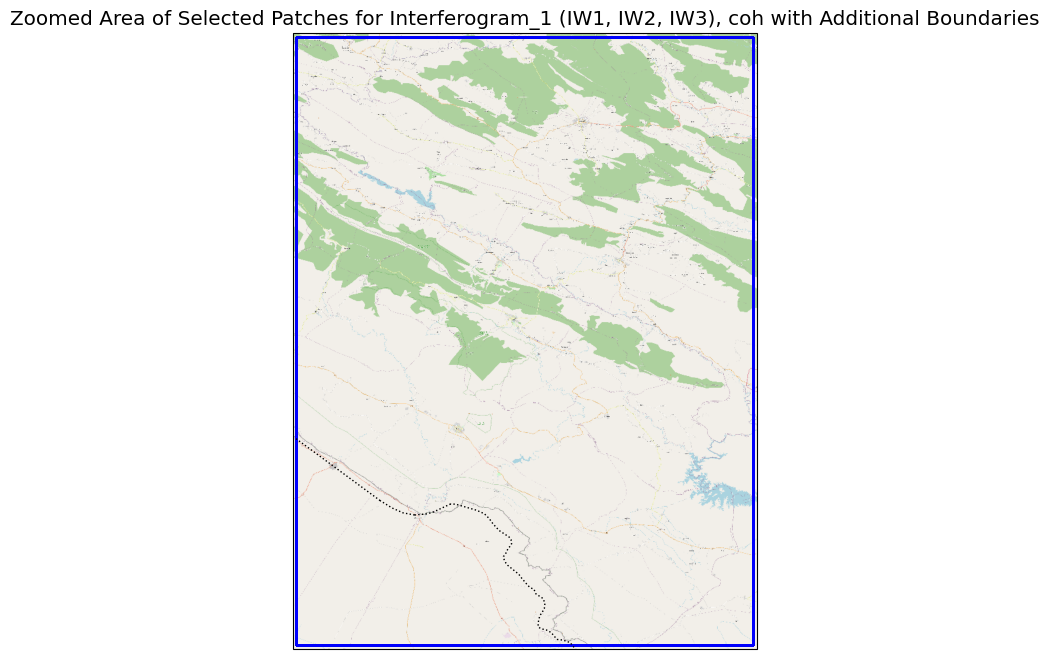

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
from cartopy.io.img_tiles import OSM

# Load data
file_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'  # Update with your actual file path
patch_data = pd.read_csv(file_path)

# Filter data to include only patches for Interferogram_1 with iw_band values IW1, IW2, IW3, and coh data_type
filtered_patches = patch_data[(patch_data['interferogram'] == 'Interferogram_1') & 
                              (patch_data['iw_band']=='IW1') & 
                              (patch_data['data_type'] == 'coh')]

# Check if the filtered DataFrame is empty
if filtered_patches.empty:
    print("No relevant patches found for the specified conditions.")
else:
    # Plotting patches on a map with Cartopy
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)

    # Set extent to cover only the area of Interferogram_1 patches across IW1, IW2, and IW3
    margin = 0.01  # Add a small margin around the patches
    ax.set_extent([
        filtered_patches[['first_near_lon', 'first_far_lon', 'last_far_lon', 'last_near_lon']].min().min() - margin,
        filtered_patches[['first_near_lon', 'first_far_lon', 'last_far_lon', 'last_near_lon']].max().max() + margin,
        filtered_patches[['first_near_lat', 'first_far_lat', 'last_far_lat', 'last_near_lat']].min().min() - margin,
        filtered_patches[['first_near_lat', 'first_far_lat', 'last_far_lat', 'last_near_lat']].max().max() + margin
    ])

    # Add OSM background map
    tile = OSM()
    ax.add_image(tile, 12)  # Adjust the zoom level for a closer look

    # Plot each patch using the boundary coordinates
    for _, row in filtered_patches.iterrows():
        # Define the rectangle coordinates using boundary values
        lower_left_lon = min(row['first_near_lon'], row['first_far_lon'], row['last_far_lon'], row['last_near_lon'])
        upper_right_lon = max(row['first_near_lon'], row['first_far_lon'], row['last_far_lon'], row['last_near_lon'])
        lower_left_lat = min(row['first_near_lat'], row['first_far_lat'], row['last_far_lat'], row['last_near_lat'])
        upper_right_lat = max(row['first_near_lat'], row['first_far_lat'], row['last_far_lat'], row['last_near_lat'])
        
        # Calculate width and height in degrees
        width = upper_right_lon - lower_left_lon
        height = upper_right_lat - lower_left_lat

        # Create a border-only rectangle
        rect = Rectangle(
            (lower_left_lon, lower_left_lat), width, height, transform=ccrs.PlateCarree(),
            fill=False, edgecolor='blue', linewidth=1
        )
        ax.add_patch(rect)

    plt.title("Zoomed Area of Selected Patches for Interferogram_1 (IW1, IW2, IW3), coh with Additional Boundaries")
    plt.show()


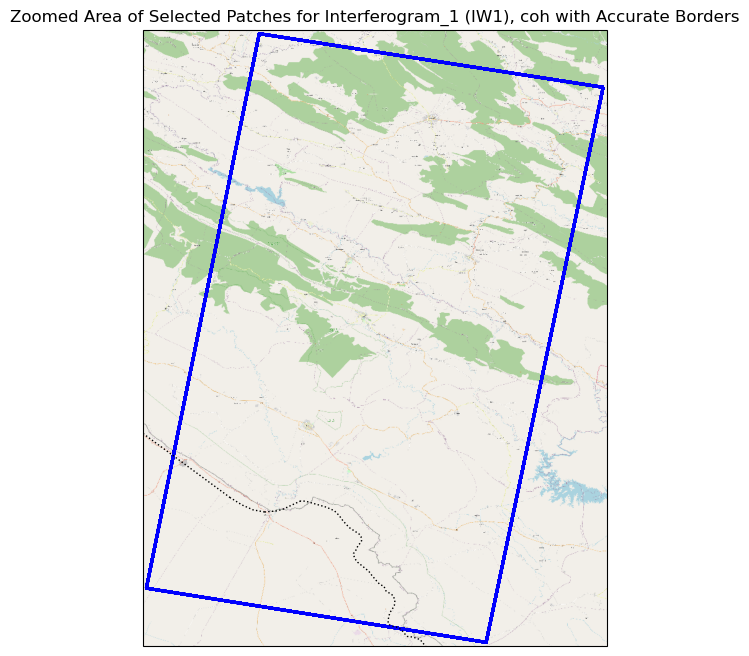

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
from cartopy.io.img_tiles import OSM
import geopandas as gpd

# Load data
file_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'  # Update with your actual file path
patch_data = pd.read_csv(file_path)

# Filter data to include only patches for Interferogram_1 with IW1 and coh data_type
filtered_patches = patch_data[(patch_data['interferogram'] == 'Interferogram_1') & 
                              (patch_data['iw_band'] == 'IW1') & 
                              (patch_data['data_type'] == 'coh')]

# Check if the filtered DataFrame is empty
if filtered_patches.empty:
    print("No relevant patches found for the specified conditions.")
else:
    # Create a GeoDataFrame to store polygons
    polygons = []
    
    # Create polygons from each patch's boundary coordinates
    for _, row in filtered_patches.iterrows():
        # Define the four corners of the patch as (lon, lat) points
        corners = [
            (row['first_near_lon'], row['first_near_lat']),
            (row['first_far_lon'], row['first_far_lat']),
            (row['last_far_lon'], row['last_far_lat']),
            (row['last_near_lon'], row['last_near_lat']),
            (row['first_near_lon'], row['first_near_lat'])  # Closing the polygon
        ]
        # Create a Polygon from the corners
        polygons.append(Polygon(corners))
    
    # Create a GeoDataFrame for plotting
    gdf = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")

    # Plotting patches on a map with Cartopy
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)

    # Set extent to cover only the area of Interferogram_1 patches for IW1
    margin = 0.01  # Add a small margin around the patches
    ax.set_extent([
        filtered_patches[['first_near_lon', 'first_far_lon', 'last_far_lon', 'last_near_lon']].min().min() - margin,
        filtered_patches[['first_near_lon', 'first_far_lon', 'last_far_lon', 'last_near_lon']].max().max() + margin,
        filtered_patches[['first_near_lat', 'first_far_lat', 'last_far_lat', 'last_near_lat']].min().min() - margin,
        filtered_patches[['first_near_lat', 'first_far_lat', 'last_far_lat', 'last_near_lat']].max().max() + margin
    ])

    # Add OSM background map
    tile = OSM()
    ax.add_image(tile, 12)  # Adjust the zoom level for a closer look

    # Plot each patch as a polygon with a border
    gdf.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2, transform=ccrs.PlateCarree())

    plt.title("Zoomed Area of Selected Patches for Interferogram_1 (IW1), coh with Accurate Borders")
    plt.show()

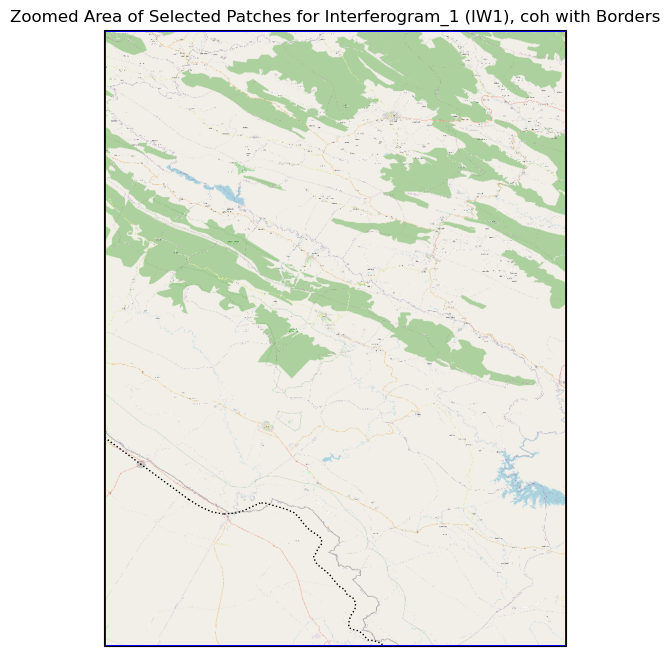

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
from cartopy.io.img_tiles import OSM

# Load data
file_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'  # Update with your actual file path
patch_data = pd.read_csv(file_path)

# Filter data to include only patches for Interferogram_1 with IW1 and coh data_type
filtered_patches = patch_data[(patch_data['interferogram'] == 'Interferogram_1') & 
                              (patch_data['iw_band'] == 'IW1') & 
                              (patch_data['data_type'] == 'coh')]

# Check if the filtered DataFrame is empty
if filtered_patches.empty:
    print("No relevant patches found for the specified conditions.")
else:
    # Plotting patches on a map with Cartopy
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)

    # Set extent to cover only the area of Interferogram_1 patches for IW1
    #margin = 0.01  # Add a small margin around the patches
    ax.set_extent([
        filtered_patches[['first_near_lon', 'first_far_lon', 'last_far_lon', 'last_near_lon']].min().min(), #- margin,
        filtered_patches[['first_near_lon', 'first_far_lon', 'last_far_lon', 'last_near_lon']].max().max(), #+ margin,
        filtered_patches[['first_near_lat', 'first_far_lat', 'last_far_lat', 'last_near_lat']].min().min(), #- margin,
        filtered_patches[['first_near_lat', 'first_far_lat', 'last_far_lat', 'last_near_lat']].max().max() #+ margin
    ])

    # Add OSM background map
    tile = OSM()
    ax.add_image(tile, 12)  # Adjust the zoom level for a closer look

    # Plot each patch with a distinct color for better visibility
    for _, row in filtered_patches.iterrows():
        # Define the rectangle coordinates using boundary values
        lower_left_lon = min(row['first_near_lon'], row['first_far_lon'], row['last_far_lon'], row['last_near_lon'])
        upper_right_lon = max(row['first_near_lon'], row['first_far_lon'], row['last_far_lon'], row['last_near_lon'])
        lower_left_lat = min(row['first_near_lat'], row['first_far_lat'], row['last_far_lat'], row['last_near_lat'])
        upper_right_lat = max(row['first_near_lat'], row['first_far_lat'], row['last_far_lat'], row['last_near_lat'])
        
        # Calculate width and height in degrees
        width = upper_right_lon - lower_left_lon
        height = upper_right_lat - lower_left_lat

        # Create a border-only rectangle with a color and thicker border
        rect = Rectangle(
            (lower_left_lon, lower_left_lat), width, height, transform=ccrs.PlateCarree(),
            fill=False, edgecolor='blue', linewidth=2
        )
        ax.add_patch(rect)

    plt.title("Zoomed Area of Selected Patches for Interferogram_1 (IW1), coh with Borders")
    plt.show()

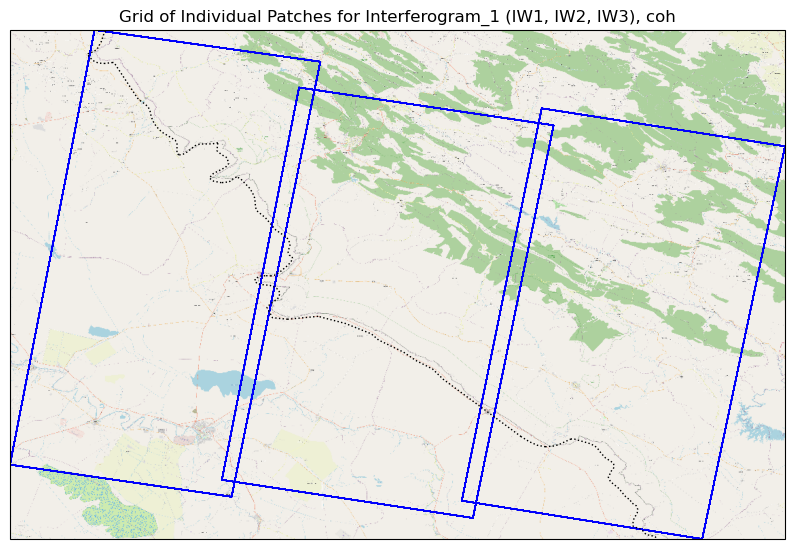

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
from cartopy.io.img_tiles import OSM
import geopandas as gpd

# Load data
file_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'  # Update with your actual file path
patch_data = pd.read_csv(file_path)

# Filter data to include only patches for Interferogram_1 with IW1, IW2, IW3 and coh data_type
filtered_patches = patch_data[(patch_data['interferogram'] == 'Interferogram_1') & 
                              (patch_data['iw_band'].isin(['IW1', 'IW2', 'IW3'])) & 
                              (patch_data['data_type'] == 'coh')]

# Check if the filtered DataFrame is empty
if filtered_patches.empty:
    print("No relevant patches found for the specified conditions.")
else:
    # Create a GeoDataFrame to store polygons for each patch
    patches = []
    
    # Create polygons for each individual patch's boundary coordinates
    for _, row in filtered_patches.iterrows():
        # Define the four corners of the patch as (lon, lat) points
        corners = [
            (row['first_near_lon'], row['first_near_lat']),
            (row['first_far_lon'], row['first_far_lat']),
            (row['last_far_lon'], row['last_far_lat']),
            (row['last_near_lon'], row['last_near_lat']),
            (row['first_near_lon'], row['first_near_lat'])  # Closing the polygon
        ]
        # Create a Polygon from the corners
        patches.append(Polygon(corners))
    
    # Create a GeoDataFrame for plotting each patch
    gdf = gpd.GeoDataFrame(geometry=patches, crs="EPSG:4326")

    # Plotting patches on a map with Cartopy
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)

    # Set extent to cover only the area of Interferogram_1 patches for IW1, IW2, and IW3

    ax.set_extent([
        filtered_patches[['first_near_lon', 'first_far_lon', 'last_far_lon', 'last_near_lon']].min().min() ,
        filtered_patches[['first_near_lon', 'first_far_lon', 'last_far_lon', 'last_near_lon']].max().max() ,
        filtered_patches[['first_near_lat', 'first_far_lat', 'last_far_lat', 'last_near_lat']].min().min() ,
        filtered_patches[['first_near_lat', 'first_far_lat', 'last_far_lat', 'last_near_lat']].max().max()
    ])

    # Add OSM background map
    tile = OSM()
    ax.add_image(tile, 12)  # Adjust the zoom level for a closer look

    # Plot each individual patch as a small polygon with borders
    gdf.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=0.8, transform=ccrs.PlateCarree())

    plt.title("Grid of Individual Patches for Interferogram_1 (IW1, IW2, IW3), coh")
    plt.show()


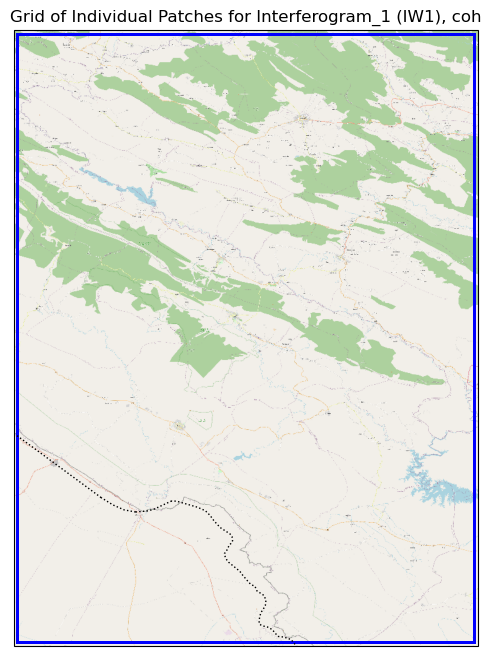

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
from cartopy.io.img_tiles import OSM

# Load data
file_path = '/mnt/data/final_patch_coordinates.csv'  # Update with your actual file path
patch_data = pd.read_csv(file_path)

# Filter data to include only patches for Interferogram_1 with IW1 and coh data_type
filtered_patches = patch_data[(patch_data['interferogram'] == 'Interferogram_1') & 
                              (patch_data['iw_band'] == 'IW1') & 
                              (patch_data['data_type'] == 'coh')]

# Check if the filtered DataFrame is empty
if filtered_patches.empty:
    print("No relevant patches found for the specified conditions.")
else:
    # Plotting patches on a map with Cartopy
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)

    # Set extent to cover only the area of Interferogram_1 patches for IW1
    margin = 0.01  # Add a small margin around the patches
    ax.set_extent([
        filtered_patches[['first_near_lon', 'first_far_lon', 'last_far_lon', 'last_near_lon']].min().min() - margin,
        filtered_patches[['first_near_lon', 'first_far_lon', 'last_far_lon', 'last_near_lon']].max().max() + margin,
        filtered_patches[['first_near_lat', 'first_far_lat', 'last_far_lat', 'last_near_lat']].min().min() - margin,
        filtered_patches[['first_near_lat', 'first_far_lat', 'last_far_lat', 'last_near_lat']].max().max() + margin
    ])

    # Add OSM background map
    tile = OSM()
    ax.add_image(tile, 12)  # Adjust the zoom level for a closer look

    # Plot each patch using the boundary coordinates as rectangles
    for _, row in filtered_patches.iterrows():
        # Define the rectangle using the four corners
        lower_left_lon = min(row['first_near_lon'], row['first_far_lon'], row['last_far_lon'], row['last_near_lon'])
        upper_right_lon = max(row['first_near_lon'], row['first_far_lon'], row['last_far_lon'], row['last_near_lon'])
        lower_left_lat = min(row['first_near_lat'], row['first_far_lat'], row['last_far_lat'], row['last_near_lat'])
        upper_right_lat = max(row['first_near_lat'], row['first_far_lat'], row['last_far_lat'], row['last_near_lat'])
        
        # Calculate width and height in degrees
        width = upper_right_lon - lower_left_lon
        height = upper_right_lat - lower_left_lat

        # Create a border-only rectangle
        rect = Rectangle(
            (lower_left_lon, lower_left_lat), width, height, transform=ccrs.PlateCarree(),
            fill=False, edgecolor='blue', linewidth=1.5
        )
        ax.add_patch(rect)

    plt.title("Grid of Individual Patches for Interferogram_1 (IW1), coh")
    plt.show()


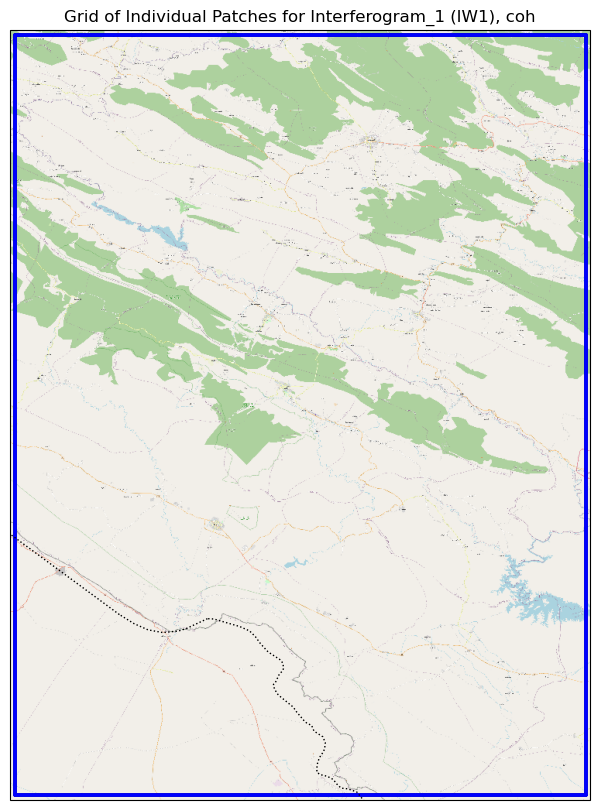

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
from cartopy.io.img_tiles import OSM

file_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'  # Update with your actual file path
patch_data = pd.read_csv(file_path)

# Filter data to include only patches for Interferogram_1 with IW1 and coh data_type
filtered_patches = patch_data[(patch_data['interferogram'] == 'Interferogram_1') & 
                              (patch_data['iw_band'] == 'IW1') & 
                              (patch_data['data_type'] == 'coh')]

# Check if the filtered DataFrame is empty
if filtered_patches.empty:
    print("No relevant patches found for the specified conditions.")
else:
    # Plotting patches on a map with Cartopy
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)

    # Set extent to cover only the area of Interferogram_1 patches for IW1
    margin = 0.01  # Add a small margin around the patches
    ax.set_extent([
        filtered_patches[['first_near_lon', 'first_far_lon', 'last_far_lon', 'last_near_lon']].min().min() - margin,
        filtered_patches[['first_near_lon', 'first_far_lon', 'last_far_lon', 'last_near_lon']].max().max() + margin,
        filtered_patches[['first_near_lat', 'first_far_lat', 'last_far_lat', 'last_near_lat']].min().min() - margin,
        filtered_patches[['first_near_lat', 'first_far_lat', 'last_far_lat', 'last_near_lat']].max().max() + margin
    ])

    # Add OSM background map
    tile = OSM()
    ax.add_image(tile, 12)  # Adjust the zoom level for a closer look

    # Plot each patch using the boundary coordinates as rectangles
    for _, row in filtered_patches.iterrows():
        # Define the rectangle using the four corners
        lower_left_lon = min(row['first_near_lon'], row['first_far_lon'], row['last_far_lon'], row['last_near_lon'])
        upper_right_lon = max(row['first_near_lon'], row['first_far_lon'], row['last_far_lon'], row['last_near_lon'])
        lower_left_lat = min(row['first_near_lat'], row['first_far_lat'], row['last_far_lat'], row['last_near_lat'])
        upper_right_lat = max(row['first_near_lat'], row['first_far_lat'], row['last_far_lat'], row['last_near_lat'])
        
        # Calculate width and height in degrees
        width = upper_right_lon - lower_left_lon
        height = upper_right_lat - lower_left_lat

        # Create a border-only rectangle
        rect = Rectangle(
            (lower_left_lon, lower_left_lat), width, height, transform=ccrs.PlateCarree(),
            fill=False, edgecolor='blue', linewidth=1.5
        )
        ax.add_patch(rect)

    plt.title("Grid of Individual Patches for Interferogram_1 (IW1), coh")
    plt.show()


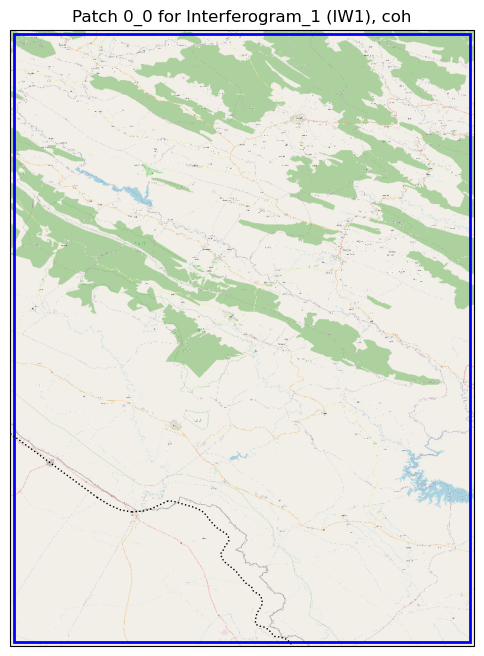

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
from cartopy.io.img_tiles import OSM

file_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'
patch_data = pd.read_csv(file_path)

# Filter data to include only the specific patch for patch_0_0, IW1, and coh data_type
specific_patch = patch_data[(patch_data['interferogram'] == 'Interferogram_1') & 
                            (patch_data['iw_band'] == 'IW1') & 
                            (patch_data['data_type'] == 'coh') & 
                            (patch_data['patch'] == 'patch_0_0')]

# Check if the filtered DataFrame is empty
if specific_patch.empty:
    print("No relevant patches found for patch_0_0.")
else:
    # Plotting the specific patch on a map with Cartopy
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)

    # Set extent to cover only the area of the specific patch
    margin = 0.01  # Add a small margin around the patch
    ax.set_extent([
        specific_patch[['first_near_lon', 'first_far_lon', 'last_far_lon', 'last_near_lon']].min().min() - margin,
        specific_patch[['first_near_lon', 'first_far_lon', 'last_far_lon', 'last_near_lon']].max().max() + margin,
        specific_patch[['first_near_lat', 'first_far_lat', 'last_far_lat', 'last_near_lat']].min().min() - margin,
        specific_patch[['first_near_lat', 'first_far_lat', 'last_far_lat', 'last_near_lat']].max().max() + margin
    ])

    # Add OSM background map
    tile = OSM()
    ax.add_image(tile, 12)  # Adjust the zoom level for a closer look

    # Plot the specific patch using the boundary coordinates as a rectangle
    row = specific_patch.iloc[0]
    lower_left_lon = min(row['first_near_lon'], row['first_far_lon'], row['last_far_lon'], row['last_near_lon'])
    upper_right_lon = max(row['first_near_lon'], row['first_far_lon'], row['last_far_lon'], row['last_near_lon'])
    lower_left_lat = min(row['first_near_lat'], row['first_far_lat'], row['last_far_lat'], row['last_near_lat'])
    upper_right_lat = max(row['first_near_lat'], row['first_far_lat'], row['last_far_lat'], row['last_near_lat'])
    
    # Calculate width and height
    width = upper_right_lon - lower_left_lon
    height = upper_right_lat - lower_left_lat

    # Create a border-only rectangle
    rect = Rectangle(
        (lower_left_lon, lower_left_lat), width, height, transform=ccrs.PlateCarree(),
        fill=False, edgecolor='blue', linewidth=2
    )
    ax.add_patch(rect)

    plt.title("Patch 0_0 for Interferogram_1 (IW1), coh")
    plt.show()
